<a href="https://colab.research.google.com/github/Tejas-Chaudhari-007/EE-769-Introduction-to-Machine-Learning/blob/main/Project_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Good: Household Poverty Level Predictions

Course: EE 769 (Introduction to Machine Learning)

Instructor: Prof. [Amit Sethi](https://www.ee.iitb.ac.in/~asethi/)

Project by: Tejas Chaudhari


# Libraries

In [ ]:
import math
import time
from collections import OrderedDict
from pprint import pprint

# Data manipulation
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

# Machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
!pip install lightgbm
from lightgbm import LGBMClassifier

# Performance metrics
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Miscellaneous
from sklearn.manifold import TSNE # Visualization in reduced dimension
from sklearn.utils import class_weight # For imbalanced classification problems
from sklearn.feature_selection import RFECV # Feature engineering
from joblib import dump, load # Save and load models
from sklearn.model_selection import StratifiedKFold

     |████████████████████████████████| 69.2MB 63kB/s 


# Preliminary data processing

## Read data and data types

In [ ]:
# Read seen data
as_read_data_df = pd.read_csv('/content/drive/MyDrive/EE 769/Project/data/train.csv')

# Display
display(as_read_data_df)

Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  \
0     ID_279628684  190000.0       0      3       0     1       1     0   
1     ID_f29eb3ddd  135000.0       0      4       0     1       1     1   
2     ID_68de51c94       NaN       0      8       0     1       1     0   
3     ID_d671db89c  180000.0       0      5       0     1       1     1   
4     ID_d56d6f5f5  180000.0       0      5       0     1       1     1   
...            ...       ...     ...    ...     ...   ...     ...   ...   
9552  ID_d45ae367d   80000.0       0      6       0     1       1     0   
9553  ID_c94744e07   80000.0       0      6       0     1       1     0   
9554  ID_85fc658f8   80000.0       0      6       0     1       1     0   
9555  ID_ced540c61   80000.0       0      6       0     1       1     0   
9556  ID_a38c64491   80000.0       0      6       0     1       1     0   

      v18q1  r4h1  r4h2  r4h3  r4m1  r4m2  r4m3  r4t1  r4t2  r4t3  tamhog  \
0       NaN     0     1     1     0     0     0     0     1     1       1   
1       1.0     0     1     1     0     0     0     0     1     1       1   
2       NaN     0     0     0     0     1     1     0     1     1       1   
3       1.0     0     2     2     1     1     2     1     3     4       4   
4       1.0     0     2     2     1     1     2     1     3     4       4   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...     ...   
9552    NaN     0     2     2     1     2     3     1     4     5       5   
9553    NaN     0     2     2     1     2     3     1     4     5       5   
9554    NaN     0     2     2     1     2     3     1     4     5       5   
9555    NaN     0     2     2     1     2     3     1     4     5       5   
9556    NaN     0     2     2     1     2     3     1     4     5       5   

      tamviv  escolari  rez_esc  hhsize  paredblolad  paredzocalo  paredpreb  \
0          1        10      NaN       1            1            0          0   
1          1        12      NaN       1            0            0          0   
2          1        11      NaN       1            0            0          0   
3          4         9      1.0       4            1            0          0   
4          4        11      NaN       4            1            0          0   
...      ...       ...      ...     ...          ...          ...        ...   
9552       5         9      NaN       5            1            0          0   
9553       5         0      NaN       5            1            0          0   
9554       5         5      NaN       5            1            0          0   
9555       5        11      NaN       5            1            0          0   
9556       5         8      NaN       5            1            0          0   

      pareddes  paredmad  paredzinc  paredfibras  paredother  pisomoscer  \
0            0         0          0            0           0           1   
1            0         1          0            0           0           0   
2            0         1          0            0           0           1   
3            0         0          0            0           0           1   
4            0         0          0            0           0           1   
...        ...       ...        ...          ...         ...         ...   
9552         0         0          0            0           0           0   
9553         0         0          0            0           0           0   
9554         0         0          0            0           0           0   
9555         0         0          0            0           0           0   
9556         0         0          0            0           0           0   

      pisocemento  pisoother  pisonatur  pisonotiene  pisomadera  techozinc  \
0               0          0          0            0           0          0   
1               0          0          0            0           1          1   
2               0          0          0            0           0          1   


In [ ]:
as_read_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


Observations:
1. 9557 total samples
2. 143 columns (including target): 138 numerical, 5 categorical 

## Store id column names in a dictionary

In [ ]:
# Initialize dictionary to store columns to drop
column_names_sets_dict = OrderedDict()

# Add id columns
column_names_sets_dict['Id columns'] = ['Id', 'idhogar']

# Display
pprint(column_names_sets_dict)

OrderedDict([('Id columns', ['Id', 'idhogar'])])


## Unique values by data types

### Int data

In [ ]:
as_read_data_df.select_dtypes('int64')

hacdor  rooms  hacapo  v14a  refrig  v18q  r4h1  r4h2  r4h3  r4m1  r4m2  \
0          0      3       0     1       1     0     0     1     1     0     0   
1          0      4       0     1       1     1     0     1     1     0     0   
2          0      8       0     1       1     0     0     0     0     0     1   
3          0      5       0     1       1     1     0     2     2     1     1   
4          0      5       0     1       1     1     0     2     2     1     1   
...      ...    ...     ...   ...     ...   ...   ...   ...   ...   ...   ...   
9552       0      6       0     1       1     0     0     2     2     1     2   
9553       0      6       0     1       1     0     0     2     2     1     2   
9554       0      6       0     1       1     0     0     2     2     1     2   
9555       0      6       0     1       1     0     0     2     2     1     2   
9556       0      6       0     1       1     0     0     2     2     1     2   

      r4m3  r4t1  r4t2  r4t3  tamhog  tamviv  escolari  hhsize  paredblolad  \
0        0     0     1     1       1       1        10       1            1   
1        0     0     1     1       1       1        12       1            0   
2        1     0     1     1       1       1        11       1            0   
3        2     1     3     4       4       4         9       4            1   
4        2     1     3     4       4       4        11       4            1   
...    ...   ...   ...   ...     ...     ...       ...     ...          ...   
9552     3     1     4     5       5       5         9       5            1   
9553     3     1     4     5       5       5         0       5            1   
9554     3     1     4     5       5       5         5       5            1   
9555     3     1     4     5       5       5        11       5            1   
9556     3     1     4     5       5       5         8       5            1   

      paredzocalo  paredpreb  pareddes  paredmad  paredzinc  paredfibras  \
0               0          0         0         0          0            0   
1               0          0         0         1          0            0   
2               0          0         0         1          0            0   
3               0          0         0         0          0            0   
4               0          0         0         0          0            0   
...           ...        ...       ...       ...        ...          ...   
9552            0          0         0         0          0            0   
9553            0          0         0         0          0            0   
9554            0          0         0         0          0            0   
9555            0          0         0         0          0            0   
9556            0          0         0         0          0            0   

      paredother  pisomoscer  pisocemento  pisoother  pisonatur  pisonotiene  \
0              0           1            0          0          0            0   
1              0           0            0          0          0            0   
2              0           1            0          0          0            0   
3              0           1            0          0          0            0   
4              0           1            0          0          0            0   
...          ...         ...          ...        ...        ...          ...   
9552           0           0            1          0          0            0   
9553           0           0            1          0          0            0   
9554           0           0            1          0          0            0   
9555           0           0            1          0          0            0   
9556           0           0            1          0          0            0   

      pisomadera  techozinc  techoentrepiso  techocane  techootro  cielorazo  \
0              0          0               1          0          0          1   
1              1          1               0       

In [ ]:
as_read_data_df.select_dtypes('int64').nunique()

hacdor             2
rooms             11
hacapo             2
v14a               2
refrig             2
                  ..
SQBhogar_total    13
SQBedjefe         22
SQBhogar_nin      10
agesq             97
Target             4
Length: 130, dtype: int64

In [ ]:
as_read_data_df.select_dtypes('int64').nunique().value_counts()

2     101
13      5
97      3
22      3
11      3
10      3
9       3
7       3
6       2
4       2
14      1
1       1
dtype: int64

Text(0, 0.5, 'Counts')

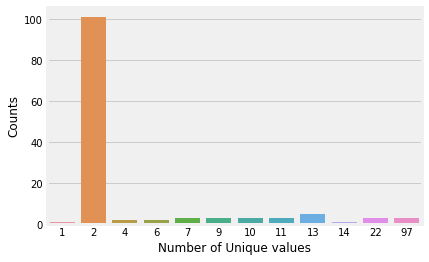

In [ ]:
sns.barplot(x=as_read_data_df.select_dtypes('int64').nunique().value_counts().index, y=as_read_data_df.select_dtypes('int64').nunique().value_counts())
plt.xlabel('Number of Unique values')
plt.ylabel('Counts')

Observations:
1. Most of the int variables seems boolean, which matches with feature descriptions given with the data.

### Float data

In [ ]:
as_read_data_df.select_dtypes('float64')

v2a1  v18q1  rez_esc  meaneduc  overcrowding  SQBovercrowding  \
0     190000.0    NaN      NaN     10.00      1.000000         1.000000   
1     135000.0    1.0      NaN     12.00      1.000000         1.000000   
2          NaN    NaN      NaN     11.00      0.500000         0.250000   
3     180000.0    1.0      1.0     11.00      1.333333         1.777778   
4     180000.0    1.0      NaN     11.00      1.333333         1.777778   
...        ...    ...      ...       ...           ...              ...   
9552   80000.0    NaN      NaN      8.25      1.250000         1.562500   
9553   80000.0    NaN      NaN      8.25      1.250000         1.562500   
9554   80000.0    NaN      NaN      8.25      1.250000         1.562500   
9555   80000.0    NaN      NaN      8.25      1.250000         1.562500   
9556   80000.0    NaN      NaN      8.25      1.250000         1.562500   

      SQBdependency  SQBmeaned  
0            0.0000   100.0000  
1           64.0000   144.0000  
2           64.0000   121.0000  
3            1.0000   121.0000  
4            1.0000   121.0000  
...             ...        ...  
9552         0.0625    68.0625  
9553         0.0625    68.0625  
9554         0.0625    68.0625  
9555         0.0625    68.0625  
9556         0.0625    68.0625  

[9557 rows x 8 columns]

In [ ]:
as_read_data_df.select_dtypes('float64').nunique()

v2a1               157
v18q1                6
rez_esc              6
meaneduc           155
overcrowding        38
SQBovercrowding     38
SQBdependency       31
SQBmeaned          155
dtype: int64

In [ ]:
as_read_data_df['v18q1'].unique()

array([nan,  1.,  2.,  3.,  4.,  5.,  6.])

In [ ]:
as_read_data_df['rez_esc'].unique()

array([nan,  1.,  0.,  3.,  2.,  4.,  5.])

Observations:
1. 'v18q1' and 'rez_esc' are actually integral and have missing values.

### Object data

In [ ]:
as_read_data_df.select_dtypes('object')

Id    idhogar dependency edjefe edjefa
0     ID_279628684  21eb7fcc1         no     10     no
1     ID_f29eb3ddd  0e5d7a658          8     12     no
2     ID_68de51c94  2c7317ea8          8     no     11
3     ID_d671db89c  2b58d945f        yes     11     no
4     ID_d56d6f5f5  2b58d945f        yes     11     no
...            ...        ...        ...    ...    ...
9552  ID_d45ae367d  d6c086aa3        .25      9     no
9553  ID_c94744e07  d6c086aa3        .25      9     no
9554  ID_85fc658f8  d6c086aa3        .25      9     no
9555  ID_ced540c61  d6c086aa3        .25      9     no
9556  ID_a38c64491  d6c086aa3        .25      9     no

[9557 rows x 5 columns]

In [ ]:
as_read_data_df.select_dtypes('object').nunique()

Id            9557
idhogar       2988
dependency      31
edjefe          22
edjefa          22
dtype: int64

In [ ]:
as_read_data_df.select_dtypes('object')

Id    idhogar dependency edjefe edjefa
0     ID_279628684  21eb7fcc1         no     10     no
1     ID_f29eb3ddd  0e5d7a658          8     12     no
2     ID_68de51c94  2c7317ea8          8     no     11
3     ID_d671db89c  2b58d945f        yes     11     no
4     ID_d56d6f5f5  2b58d945f        yes     11     no
...            ...        ...        ...    ...    ...
9552  ID_d45ae367d  d6c086aa3        .25      9     no
9553  ID_c94744e07  d6c086aa3        .25      9     no
9554  ID_85fc658f8  d6c086aa3        .25      9     no
9555  ID_ced540c61  d6c086aa3        .25      9     no
9556  ID_a38c64491  d6c086aa3        .25      9     no

[9557 rows x 5 columns]

In [ ]:
# Get string values set in columns
string_values_set = set()
for column_name in ['dependency', 'edjefe', 'edjefa']:
    for current_value in as_read_data_df[column_name]:
        if current_value.isalpha():
            string_values_set.add(current_value)

string_values_set

{'no', 'yes'}

Observations:
1. 'Id' and 'idhogar' are individual and household ids respectively. So these won't be used in the training.
2. 'dependency', 'edjefe' and 'edjefa' are of object data type only due to presence of 'yes' and 'no'

dependency: Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)

edjefe: years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

edjefa: years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

yes' and 'no' should be encoded to '1' and '0' to make these columns numerical.

## Encoding of  'dependency', 'edjefe' and 'edjefa'

In [ ]:
# Define the mapping for the encoding
mapping_dict = {
    'yes': 1,
    'no': 0
}

# Get encoded columns
encoded_columns_df = as_read_data_df[['dependency', 'edjefe', 'edjefa']].replace(to_replace=mapping_dict, inplace=False)

# 
encoded_data_v1_df = as_read_data_df.copy(deep=True) # Initialize
encoded_data_v1_df[['dependency', 'edjefe', 'edjefa']]  =encoded_columns_df # Update

# Change data types to numeric
encoded_data_v1_df[['dependency', 'edjefe', 'edjefa']] = encoded_data_v1_df[['dependency', 'edjefe', 'edjefa']].astype('float64')

# Display
display(encoded_data_v1_df[['dependency', 'edjefe', 'edjefa']].dtypes)

dependency    float64
edjefe        float64
edjefa        float64
dtype: object

In [ ]:
encoded_data_v1_df.dtypes.value_counts()

int64      130
float64     11
object       2
dtype: int64

Observations:
1. All of the data required for training is converted to numeric.
2. The 2 object columns remaining are 'id' and 'idhogar' are the id columns and not to be included in training. These should be dropped while creating input training and testing data sets.

## Missing values

2 possible approaches (covered in assignment 1):
1. Univariate imputation
2. Multivariate imputation

Useful resource:
1. https://scikit-learn.org/stable/modules/impute.html

Note: Always look if the domain knowledge can be used to fill the missing values before blindly applying the imputations.

In [ ]:
# Source code of missing values table function - https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction 
def missing_values_table(df):
        # Total missing values
        n_mising_values_list = df.isnull().sum()
        
        # Percentage of missing values
        missing_values_percent_list = 100 * df.isnull().sum() / len(df) # len(df) is total number of rows
        
        # Make a table with the results
        missing_values_table = pd.concat([n_mising_values_list, missing_values_percent_list], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = missing_values_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Missing Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Missing Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
missing_values_table(encoded_data_v1_df)

Your selected dataframe has 143 columns.
There are 5 columns that have missing values.


Missing Values  % of Missing Values
rez_esc              7928                 83.0
v18q1                7342                 76.8
v2a1                 6860                 71.8
meaneduc                5                  0.1
SQBmeaned               5                  0.1

Observations:
1. We will look into the data descriptions before blidnly applying univariate/multivariate imputation. Missing values are present in the following features:

rez_esc: years behind in school.

v18q1: number of tablets household owns.

v2a1: monthly rent payment.

meaneduc: average years of education for adults (18+)

SQBmeaned: square of the mean years of education  of adults (>=18) in the household.


### Imputation of 'rez_esc' based on domain knowledge

It is possible that the individuals who are not currently in school have null values. Lets check age of individuals with null values in rez_esc (years behind in school)

In [ ]:
as_read_data_df.loc[as_read_data_df['rez_esc'].isna(), 'age'].describe()

count    7928.000000
mean       38.833249
std        20.989486
min         0.000000
25%        24.000000
50%        38.000000
75%        54.000000
max        97.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'Age distribution of individuals with \n missing number of years behind in school data')

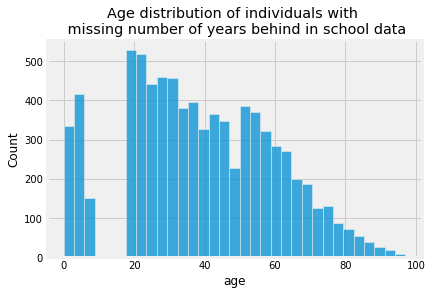

In [ ]:
sns.histplot(as_read_data_df.loc[as_read_data_df['rez_esc'].isna(), 'age'])
plt.title('Age distribution of individuals with \n missing number of years behind in school data')

Observations:
1. As expected seems like most of them are old enough not be in school. 

Next:
1. Lets look at the ages of individuals who have 'rez_esc' data available too to confirm our hypothesis.

In [ ]:
as_read_data_df.loc[as_read_data_df['rez_esc'].notna(), 'age'].describe()

count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Age distribution of individuals with \n available number of years behind in school data')

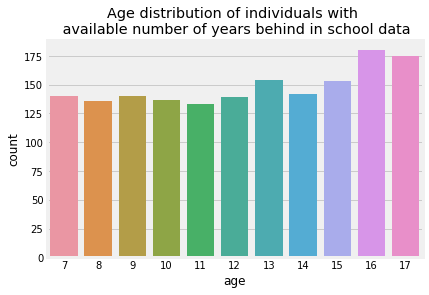

In [ ]:
sns.countplot(as_read_data_df.loc[as_read_data_df['rez_esc'].notna(), 'age'])
plt.title('Age distribution of individuals with \n available number of years behind in school data')

Observations:
1. All the individuals for whom the data of 'years behind in schhool' (rez_esc) available have age from 7 to 17. 
2. So individuals who are with age less than 7 and higher than 17 are not actually in school and hence have null values for 'years behind in schhool' (rez_esc).


Next:
1. Lets set 'rez_esc' to 0 for all the individuals who are younger than 7 years and older than 17.

In [ ]:
# Initialize imputed dataframe
imputed_data_v1_df = as_read_data_df.copy(deep=True)

# set 'rez_esc' to 0 for all the individuals who are younger than 7 years and older than 17
imputed_data_v1_df.loc[(imputed_data_v1_df['age']<7) | (imputed_data_v1_df['age']>17), 'rez_esc'] = 0

# Confirm missing values
print('Number of missing values left in rez_esc:')
print(imputed_data_v1_df['rez_esc'].isna().sum())
print('--'*50)

# Find age of the individual who still have missing value
print('Age of the individuals with null values:')
display(imputed_data_v1_df.loc[imputed_data_v1_df['rez_esc'].isna(), 'age'])

Number of missing values left in rez_esc:
1
----------------------------------------------------------------------------------------------------
Age of the individuals with null values:


2514    10
Name: age, dtype: int64

Lets fill this missing value with mode.

In [ ]:
# Check counts of values in 'rez_esc' for age from 7 to 17
display(imputed_data_v1_df.loc[(imputed_data_v1_df['age']>=7) & (imputed_data_v1_df['age']<=17), 'rez_esc'].value_counts())
print('--'*50)

# Find mode of 'rez_esc' for individuals with age between 7 and 17
mode = imputed_data_v1_df.loc[(imputed_data_v1_df['age']>=7) & (imputed_data_v1_df['age']<=17), 'rez_esc'].mode()[0]
print('Mode: ', mode)
print('--'*50)

# Impute the missing value
imputed_data_v1_df['rez_esc'].fillna(value=mode, inplace=True)

# Confirmation
print('Are there any missing values left in rez_esc? ')
imputed_data_v1_df['rez_esc'].isna().value_counts()

0.0    1211
1.0     227
2.0      98
3.0      55
4.0      29
5.0       9
Name: rez_esc, dtype: int64

----------------------------------------------------------------------------------------------------
Mode:  0.0
----------------------------------------------------------------------------------------------------
Are there any missing values left in rez_esc? 


False    9557
Name: rez_esc, dtype: int64

### Imputation of 'v18q1' based on domain knowledge

v18q1: Number of tablets

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

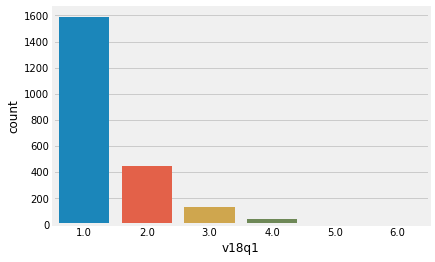

In [ ]:
# Check values present in 'v18q1'
display(imputed_data_v1_df['v18q1'].value_counts())
sns.countplot(x=imputed_data_v1_df['v18q1'])

Observations:
1. Seems like there are no households with '0' number of tablets. Which is unlikely considering the fact that the data mainly comes from the poor regions.
2. So mostly likely these missing values are zeros.

Next:
1. Lets confirm our hypothesis by checking the 'v18q' column which represents whether the individual owns a tablet or not.

In [ ]:
# Apply missing values count function on grouped values in 'v18q1' (i.e. x) based on groups in 'v18q'
imputed_data_v1_df.groupby(by='v18q')['v18q1'].apply(lambda x: x.isna().sum())

v18q
0    7342
1       0
Name: v18q1, dtype: int64

Observations:
1. There are no missing values where 'v18q' is '1', i.e., for the individuals who own a tablet. 
2. Hence our hypothesis that the missing values in 'v18q1' are actually for the individuals who do not own tablets seems to be legit.

Next:
1. Fill the missing values in the 'v18q1' with zeros.

In [ ]:
# Imputation
imputed_data_v1_df['v18q1'] = imputed_data_v1_df['v18q1'].fillna(value=0)

# Confirmation
print('Missing values left in the "v18q1" column:')
imputed_data_v1_df['v18q1'].isna().sum()

Missing values left in the "v18q1" column:


0

### Imputation of 'v2a1' based on domain knowledge

v2a1: monthly rent payment.

For this lets look at the following columns showing ownership of houses:

tipovivi1, =1 own and fully paid house

tipovivi2, "=1 own,  paying in installments"

tipovivi3, =1 rented

tipovivi4, =1 precarious

tipovivi5, "=1 other(assigned,  borrowed)"

It is possible that the individuals who are the owners have null entries in the 'v2a1' column.

Text(0.5, 0, 'Household ownership status')

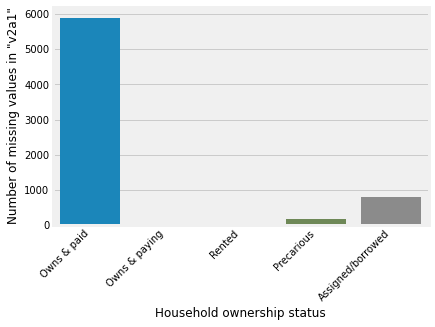

In [ ]:
# Initialize dataframe to plot
data_to_plot_df = pd.DataFrame()

# Get the counts of missing values curresponding to the household ownership variables
data_to_plot_df['Owns & paid'] = [imputed_data_v1_df.loc[imputed_data_v1_df['tipovivi1']==1, 'v2a1'].isna().sum()]
data_to_plot_df['Owns & paying'] = [imputed_data_v1_df.loc[imputed_data_v1_df['tipovivi2']==1, 'v2a1'].isna().sum()]
data_to_plot_df['Rented'] = [imputed_data_v1_df.loc[imputed_data_v1_df['tipovivi3']==1, 'v2a1'].isna().sum()]
data_to_plot_df['Precarious'] = [imputed_data_v1_df.loc[imputed_data_v1_df['tipovivi4']==1, 'v2a1'].isna().sum()]
data_to_plot_df['Assigned/borrowed'] = [imputed_data_v1_df.loc[imputed_data_v1_df['tipovivi5']==1, 'v2a1'].isna().sum()]

# Plot
sns.barplot(data=data_to_plot_df)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of missing values in "v2a1"')
plt.xlabel('Household ownership status')

Observations:
1. Our hypothesis that individuals who own a house and fully paid would have null entries in the 'v2a1' (monthly rentals) column was partially correct. However these can be set to zero
2. Rest of the missing values could be estimated using multivariate imputation before the ML modelling after splitting train and test data.

In [ ]:
# Fill the missing values in 'v2a1' for the individuals, who are owners and paid fully for the house, with zeros
imputed_data_v1_df.loc[imputed_data_v1_df['tipovivi1']==1, 'v2a1'] = 0

# Confirmation
print('Missing monthly rent payment values for owners who have paid fully: ')
imputed_data_v1_df.loc[imputed_data_v1_df['tipovivi1']==1, 'v2a1'].isna().sum()

Missing monthly rent payment values for owners who have paid fully: 


0

In [ ]:
# Lets see how many missing values are left
missing_values_table(imputed_data_v1_df)

Your selected dataframe has 143 columns.
There are 3 columns that have missing values.


Missing Values  % of Missing Values
v2a1                  949                  9.9
meaneduc                5                  0.1
SQBmeaned               5                  0.1

Observations:
1. These missing values would be imputed in data pre-processing for ML modelling after train-test split using either univariate or multivariate imputation. (Fit imputer on train data)

## Data cleaning [Error handling (target)]

Lets check if all the individuals each household is same or not.

For this we will get number of unique values in target for each household. If there is only 1 unique value in target for a household then it means that all the individuals in that household have same target and hence there is no error in the target labels in them.

In [ ]:
# Get counts of unique values in target column grouped by household index column
as_read_data_df.groupby('idhogar')['Target'].nunique().value_counts()

1    2903
2      84
3       1
Name: Target, dtype: int64

Observations:
1. '2903' labels in the target have no errors, i.e.,  2903 individuals have same poverty level labels as their other members of the household. 

Next:
1. Lets get boolean list of indices (individuals) where we have the errors and set their labels to the heads of the households.

In [ ]:
# Get the boolean list indicating if house ids have errors
incorrect_hosehold_indicators_boolean_list = as_read_data_df.groupby(by='idhogar')['Target'].apply(lambda x: x.nunique() != 1)

# Confirmation
incorrect_hosehold_indicators_boolean_list.value_counts()

False    2903
True       85
Name: Target, dtype: int64

Observations:
1. There are 85 households where poverty level labels of all the members are not the same.

In [ ]:
# List of household ids with errors
household_ids_with_errors_list = incorrect_hosehold_indicators_boolean_list[incorrect_hosehold_indicators_boolean_list].index

# Check an example
as_read_data_df.loc[as_read_data_df['idhogar']==household_ids_with_errors_list[1], ['idhogar', 'parentesco1', 'Target'] ]

idhogar  parentesco1  Target
7480  03f4e5f4d            0       2
7481  03f4e5f4d            1       1
7482  03f4e5f4d            0       1

In [ ]:
# Initialize the cleaned dataframe
cleaned_data_v1_df = as_read_data_df.copy(deep=True)

for household_id in as_read_data_df['idhogar']:
    # Check if target labels of the household members are same 
    if cleaned_data_v1_df.loc[cleaned_data_v1_df['idhogar']==household_id, 'Target'].nunique() != 1:
        # Get target label of head of the household
        head_target_label = cleaned_data_v1_df.loc[(cleaned_data_v1_df['idhogar']==household_id) & (cleaned_data_v1_df['parentesco1']==1), 'Target']

        # Set target label of all the members of household to the target of its head
        cleaned_data_v1_df.loc[cleaned_data_v1_df['idhogar']==household_id, 'Target'] = head_target_label    

# Confirmation
cleaned_data_v1_df.groupby(by='idhogar')['Target'].nunique().value_counts()

1    2988
Name: Target, dtype: int64

Observations:
1. All the target labels are corrected, i.e., members of each household have same poverty level (target).

# Combine cleaned and encoded data for EDA

In [ ]:
# Initialize the dataframe
imputed_cleaned_encoded_data_v1_df = encoded_data_v1_df.copy(deep=True)

# Update the correct target column
imputed_cleaned_encoded_data_v1_df['Target'] = cleaned_data_v1_df['Target']

# Update imputed columns so far
imputed_cleaned_encoded_data_v1_df[['rez_esc', 'v18q1', 'v2a1']] = imputed_data_v1_df[['rez_esc', 'v18q1', 'v2a1']]

# Display
imputed_cleaned_encoded_data_v1_df

Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  \
0     ID_279628684  190000.0       0      3       0     1       1     0   
1     ID_f29eb3ddd  135000.0       0      4       0     1       1     1   
2     ID_68de51c94       0.0       0      8       0     1       1     0   
3     ID_d671db89c  180000.0       0      5       0     1       1     1   
4     ID_d56d6f5f5  180000.0       0      5       0     1       1     1   
...            ...       ...     ...    ...     ...   ...     ...   ...   
9552  ID_d45ae367d   80000.0       0      6       0     1       1     0   
9553  ID_c94744e07   80000.0       0      6       0     1       1     0   
9554  ID_85fc658f8   80000.0       0      6       0     1       1     0   
9555  ID_ced540c61   80000.0       0      6       0     1       1     0   
9556  ID_a38c64491   80000.0       0      6       0     1       1     0   

      v18q1  r4h1  r4h2  r4h3  r4m1  r4m2  r4m3  r4t1  r4t2  r4t3  tamhog  \
0       0.0     0     1     1     0     0     0     0     1     1       1   
1       1.0     0     1     1     0     0     0     0     1     1       1   
2       0.0     0     0     0     0     1     1     0     1     1       1   
3       1.0     0     2     2     1     1     2     1     3     4       4   
4       1.0     0     2     2     1     1     2     1     3     4       4   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...     ...   
9552    0.0     0     2     2     1     2     3     1     4     5       5   
9553    0.0     0     2     2     1     2     3     1     4     5       5   
9554    0.0     0     2     2     1     2     3     1     4     5       5   
9555    0.0     0     2     2     1     2     3     1     4     5       5   
9556    0.0     0     2     2     1     2     3     1     4     5       5   

      tamviv  escolari  rez_esc  hhsize  paredblolad  paredzocalo  paredpreb  \
0          1        10      0.0       1            1            0          0   
1          1        12      0.0       1            0            0          0   
2          1        11      0.0       1            0            0          0   
3          4         9      1.0       4            1            0          0   
4          4        11      0.0       4            1            0          0   
...      ...       ...      ...     ...          ...          ...        ...   
9552       5         9      0.0       5            1            0          0   
9553       5         0      0.0       5            1            0          0   
9554       5         5      0.0       5            1            0          0   
9555       5        11      0.0       5            1            0          0   
9556       5         8      0.0       5            1            0          0   

      pareddes  paredmad  paredzinc  paredfibras  paredother  pisomoscer  \
0            0         0          0            0           0           1   
1            0         1          0            0           0           0   
2            0         1          0            0           0           1   
3            0         0          0            0           0           1   
4            0         0          0            0           0           1   
...        ...       ...        ...          ...         ...         ...   
9552         0         0          0            0           0           0   
9553         0         0          0            0           0           0   
9554         0         0          0            0           0           0   
9555         0         0          0            0           0           0   
9556         0         0          0            0           0           0   

      pisocemento  pisoother  pisonatur  pisonotiene  pisomadera  techozinc  \
0               0          0          0            0           0          0   
1               0          0          0            0           1          1   
2               0          0          0            0           0          1   


# Exploratory data analysis

## Numerical descriptive statstics

In [ ]:
display(imputed_cleaned_encoded_data_v1_df.describe())
imputed_cleaned_encoded_data_v1_df.agg(['skew', 'kurtosis'])

v2a1       hacdor        rooms       hacapo         v14a  \
count  8.608000e+03  9557.000000  9557.000000  9557.000000  9557.000000   
mean   5.176924e+04     0.038087     4.955530     0.023648     0.994768   
std    1.138653e+05     0.191417     1.468381     0.151957     0.072145   
min    0.000000e+00     0.000000     1.000000     0.000000     0.000000   
25%    0.000000e+00     0.000000     4.000000     0.000000     1.000000   
50%    0.000000e+00     0.000000     5.000000     0.000000     1.000000   
75%    7.000000e+04     0.000000     6.000000     0.000000     1.000000   
max    2.353477e+06     1.000000    11.000000     1.000000     1.000000   

            refrig         v18q        v18q1         r4h1         r4h2  \
count  9557.000000  9557.000000  9557.000000  9557.000000  9557.000000   
mean      0.957623     0.231767     0.325416     0.385895     1.559171   
std       0.201459     0.421983     0.697118     0.680779     1.036574   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     0.000000     0.000000     1.000000   
50%       1.000000     0.000000     0.000000     0.000000     1.000000   
75%       1.000000     0.000000     0.000000     1.000000     2.000000   
max       1.000000     1.000000     6.000000     5.000000     8.000000   

              r4h3         r4m1         r4m2         r4m3         r4t1  \
count  9557.000000  9557.000000  9557.000000  9557.000000  9557.000000   
mean      1.945066     0.399184     1.661714     2.060898     0.785079   
std       1.188852     0.692460     0.933052     1.206172     1.047559   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     0.000000     1.000000     1.000000     0.000000   
50%       2.000000     0.000000     1.000000     2.000000     0.000000   
75%       3.000000     1.000000     2.000000     3.000000     1.000000   
max       8.000000     6.000000     6.000000     8.000000     7.000000   

              r4t2         r4t3       tamhog       tamviv     escolari  \
count  9557.000000  9557.000000  9557.000000  9557.000000  9557.000000   
mean      3.220885     4.005964     3.999058     4.094590     7.200272   
std       1.440995     1.771202     1.772216     1.876428     4.730877   
min       1.000000     1.000000     1.000000     1.000000     0.000000   
25%       2.000000     3.000000     3.000000     3.000000     4.000000   
50%       3.000000     4.000000     4.000000     4.000000     6.000000   
75%       4.000000     5.000000     5.000000     5.000000    11.000000   
max      11.000000    13.000000    13.000000    15.000000    21.000000   

           rez_esc       hhsize  paredblolad  paredzocalo    paredpreb  \
count  9557.000000  9557.000000  9557.000000  9557.000000  9557.000000   
mean      0.078372     3.999058     0.594015     0.077744     0.188030   
std       0.427241     1.772216     0.491107     0.267782     0.390756   
min       0.000000     1.000000     0.000000     0.000000     0.000000   
25%       0.000000     3.000000     0.000000     0.000000     0.000000   
50%       0.000000     4.000000     1.000000     0.000000     0.000000   
75%       0.000000     5.000000     1.000000     0.000000     0.000000   
max       5.000000    13.000000     1.000000     1.000000     1.000000   

          pareddes     paredmad    paredzinc  paredfibras   paredother  \
count  9557.000000  9557.000000  9557.000000  9557.000000  9557.000000   
mean      0.008580     0.115622     0.013079     0.001465     0.001465   
std       0.092235     0.319788     0.113621     0.038248     0.038248   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

    

v2a1     hacdor     rooms     hacapo        v14a     refrig  \
skew       4.819982   4.827256  0.492808   6.270899  -13.718759  -4.544036   
kurtosis  51.146740  21.306863  0.956625  37.331987  186.243311  18.652168   

              v18q      v18q1      r4h1      r4h2      r4h3      r4m1  \
skew      1.271562   2.795130  2.164806  1.232271  0.992957  2.118286   
kurtosis -0.383211  10.157589  6.627214  3.297986  1.874247  6.515505   

              r4m2      r4m3      r4t1      r4t2      r4t3    tamhog  \
skew      1.128747  1.090578  1.763112  1.159647  1.158371  1.160054   
kurtosis  1.896036  1.816379  4.677718  2.734199  2.802964  2.811473   

            tamviv  escolari    rez_esc    hhsize  paredblolad  paredzocalo  \
skew      1.370489  0.192121   6.794292  1.160054    -0.382949     3.154384   
kurtosis  3.785751 -0.666587  52.460006  2.811473    -1.853738     7.951804   

          paredpreb    pareddes  paredmad  paredzinc  paredfibras  paredother  \
skew       1.597085   10.658006  2.404459   8.572766    26.074082   26.074082   
kurtosis   0.550796  111.616449  3.782213  71.507286   677.999614  677.999614   

          pisomoscer  pisocemento    pisoother   pisonatur  pisonotiene  \
skew       -0.835922     1.331992    32.545696   30.870701     7.609697   
kurtosis   -1.301507    -0.225844  1057.443608  951.199248    55.919193   

          pisomadera  techozinc  techoentrepiso   techocane   techootro  \
skew        3.499179  -5.518740        7.320186   17.767074   21.265921   
kurtosis   10.246401  28.462449       51.595915  313.734558  450.333638   

          cielorazo  abastaguadentro  abastaguafuera  abastaguano    public  \
skew      -0.759142        -5.040196        5.346304    16.678703 -2.415707   
kurtosis  -1.424002        23.408474       26.588533   276.236933  3.836444   

              planpri      noelec   coopele  sanitario1  sanitario2  \
skew        56.423987   21.265921  2.480141   15.980655     1.39506   
kurtosis  3182.332287  450.333638  4.151969  253.434383    -0.05382   

          sanitario3  sanitario5  sanitario6  energcocinar1  energcocinar2  \
skew       -1.245330    7.877100   19.883032      22.980690       0.041660   
kurtosis   -0.449246   60.061273  393.417275     526.222226      -1.998683   

          energcocinar3  energcocinar4  elimbasu1  elimbasu2  elimbasu3  \
skew           0.166975       4.124329  -2.379093   5.508188   2.987160   
kurtosis      -1.972532      15.013229   3.660849  28.346067   6.924574   

           elimbasu4  elimbasu5   elimbasu6   epared1   epared2   epared3  \
skew       26.074082          0   28.172097  2.622649  0.735715 -0.283481   
kurtosis  677.999614          0  791.832759  4.879311 -1.459028 -1.920041   

           etecho1   etecho2   etecho3     eviv1     eviv2     eviv3  \
skew      2.222108  0.936149 -0.339025  2.647266  1.137737 -0.611271   
kurtosis  2.938380 -1.123860 -1.885457  5.009066 -0.705702 -1.626688   

                dis      male    female  estadocivil1  estadocivil2  \
skew       3.800258  0.066386 -0.066386      2.101871      2.292410   
kurtosis  12.444565 -1.996011 -1.996011      2.418367      3.255824   

          estadocivil3  estadocivil4  estadocivil5  estadocivil6  \
skew          1.045522      5.326941      3.605468      5.214509   
kurtosis     -0.907073     26.381820     11.001703     25.196380   

          estadocivil7  parentesco1  parentesco2  parentesco3  parentesco4  \
skew          0.663051     0.816307     1.630830     0.486606     8.912079   
kurtosis     -1.560690    -1.333923     0.659744    -1.763584    77.441355   

          parentesco5  parentesco6  parentesco7  parentesco8  parentesco9  \
skew        10.102655     4.074691     9.828151    20.313879     8.502242   
kurtosis   100.084573    14.606161    94.612350   410.739637    70.302839   

          parentesco10  parentesco11  parentesco12  hogar_nin  hogar_adul  \
skew         17.767074      8.718954     10.591910   1.231530    1.370235   
kurtosi

## Graphical descriptive statistics

Pairplots are not possible due to the size of the data

### Distributions of the variables

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

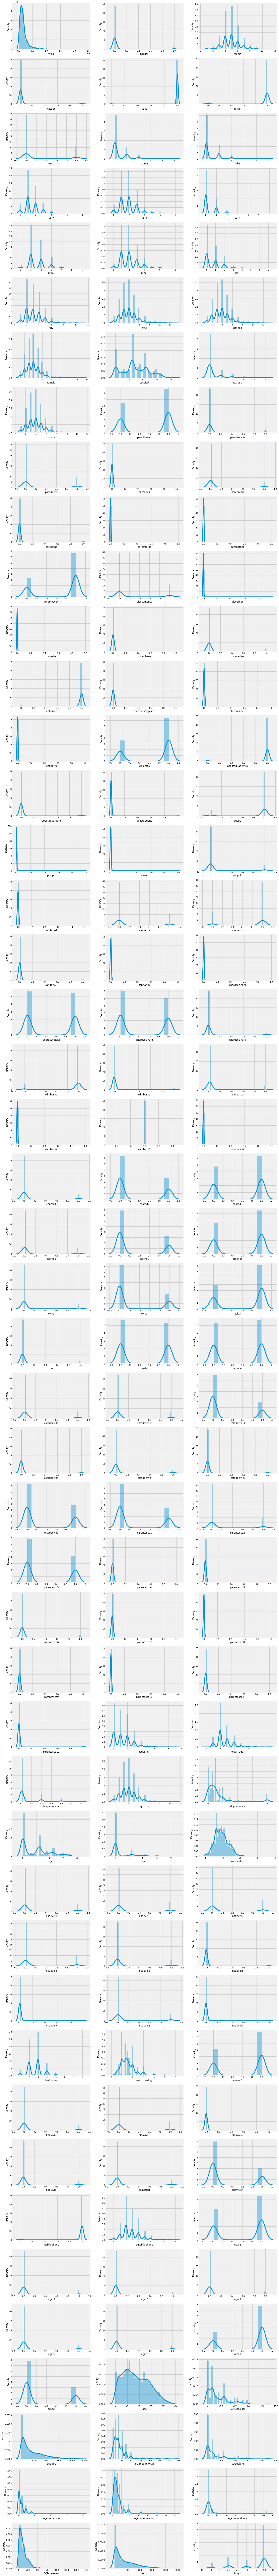

In [ ]:
# Create figure and axes array
n_cols = 3
n_rows = math.ceil(len(imputed_cleaned_encoded_data_v1_df.select_dtypes(exclude='object').columns) / n_cols)
figure, axes_array = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*7, n_rows*5))

# Initialize axes array row and column indices
i = 0 # Row index of axes array of subplots
j = 0 # Column index of axes array of subplots

# Loop over columns to plot
for column_name in encoded_data_v1_df.select_dtypes(exclude='object').columns: # 'Id' and 'idhogar' are of 'object' data type
    # Plot in the subplot
    sns.distplot(encoded_data_v1_df[column_name], ax=axes_array[i][j])

    # Reset column index of axes array of subplots
    j += 1
    if j == n_cols: 
        j = 0
        i += 1



Observations:
1. Most of the variables have discrete values. 
2. Tree based model will probably work better on this data.

### Scatter plots

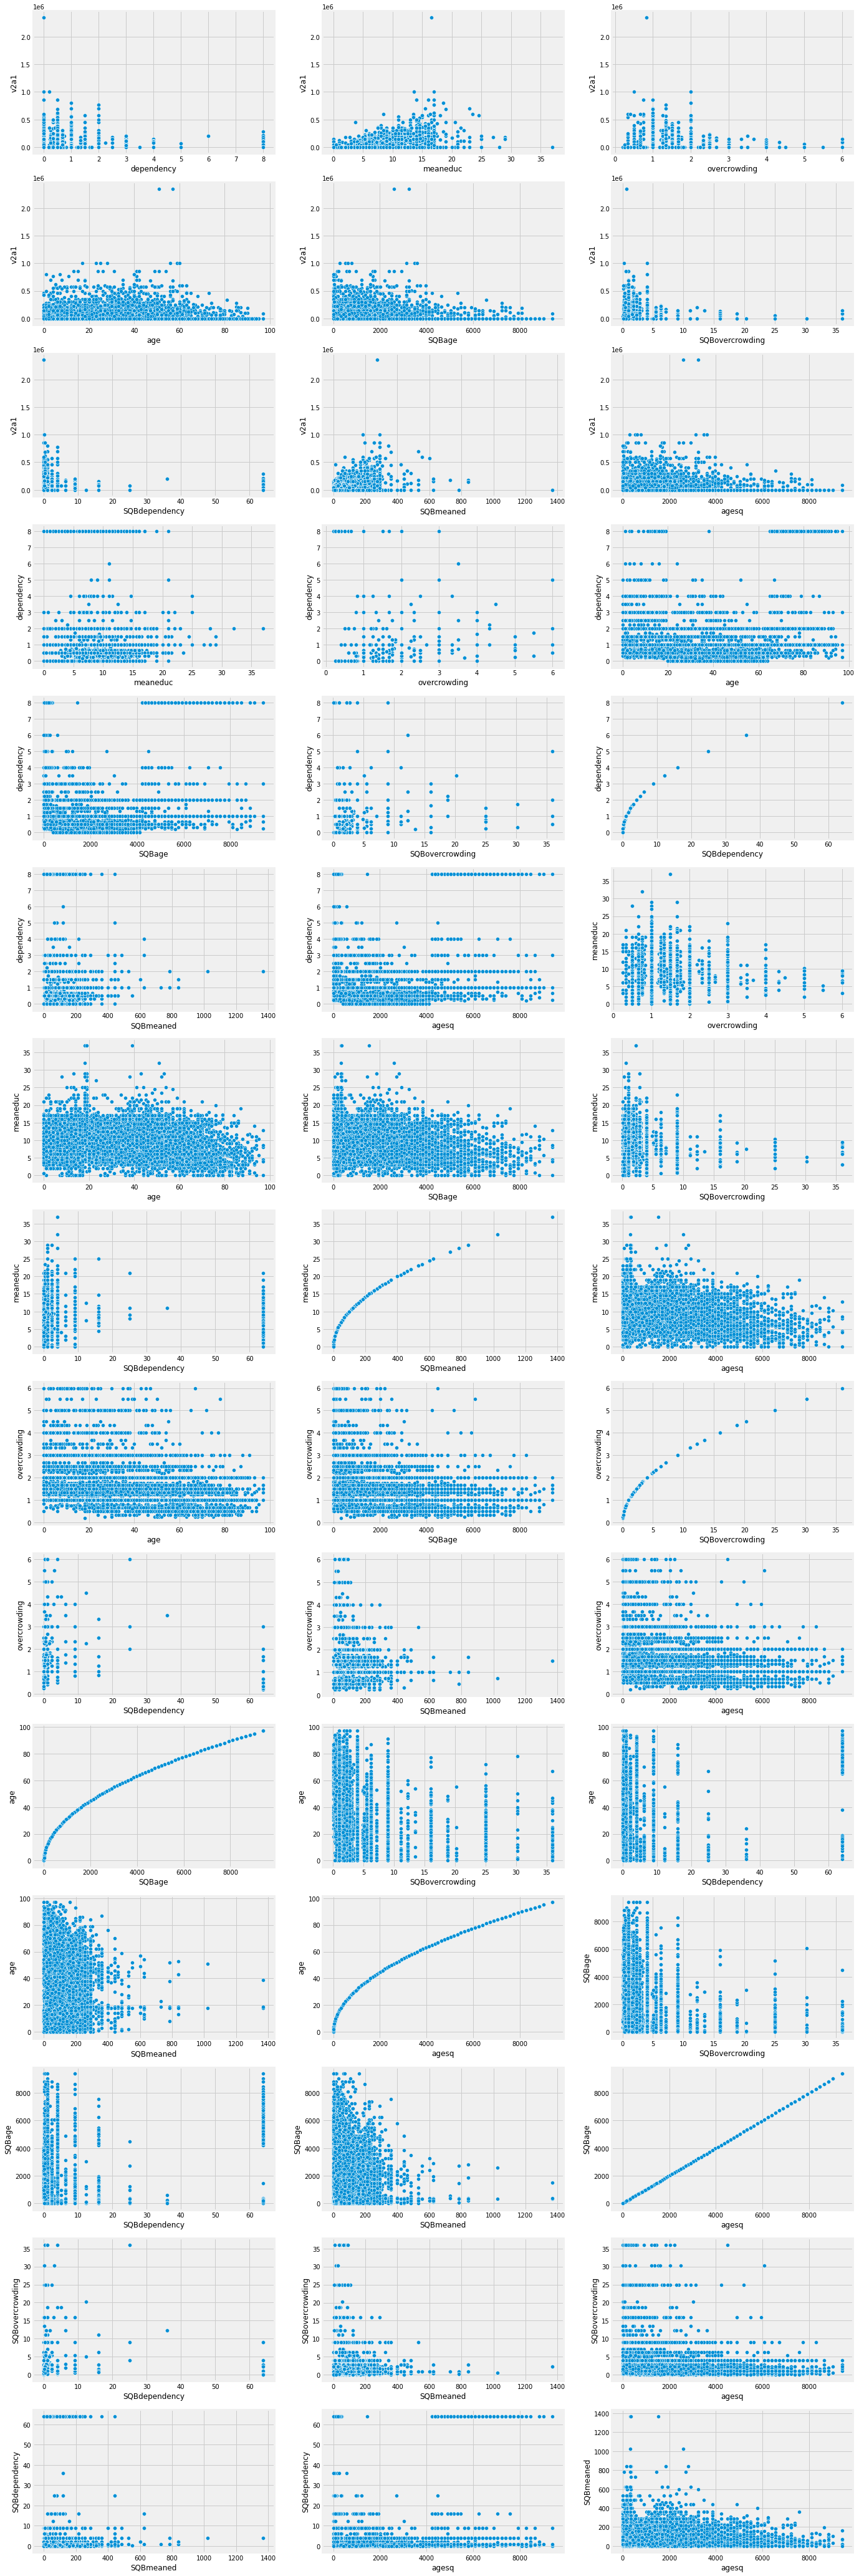

In [ ]:
# Select columns with high enough unique values to plot
max_unique_values = 30 # Set threshold for plotting columns
column_names_to_plot_list = [] #Initialize list to store the selected column names
for column_name in imputed_cleaned_encoded_data_v1_df.select_dtypes(exclude='object').columns: # Loop over numeric columns
    if imputed_cleaned_encoded_data_v1_df[column_name].nunique() >= max_unique_values:  # Check if number of unique values in columns are higher than the threshold
        column_names_to_plot_list.append(column_name)

# Create figure and axes array
n_combinations = len(column_names_to_plot_list) * (len(column_names_to_plot_list) - 1) / 2
n_cols = 3
n_rows = math.ceil(n_combinations / n_cols)
figure, axes_array = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*7, n_rows*5))

# Initialize axes array row and column indices
i = 0 # Row index of axes array of subplots
j = 0 # Column index of axes array of subplots

# Loop over columns to plot
for y_column_name in column_names_to_plot_list: # 'Id' and 'idhogar' are of 'object' data type
    for x_column_name in column_names_to_plot_list:
        # Condition which takes x columns only to the left of the y column to avoid duplicate plots
        if column_names_to_plot_list.index(y_column_name) >= column_names_to_plot_list.index(x_column_name):
            continue

        # Plot in the subplot
        sns.scatterplot(x=imputed_cleaned_encoded_data_v1_df[x_column_name], y=imputed_cleaned_encoded_data_v1_df[y_column_name], ax=axes_array[i][j])

        # Reset column index of axes array of subplots
        j += 1
        if j == n_cols: 
            j = 0
            i += 1



Observations:
1. The squared columns are correlated to its constituent variable. One of them should be dropped.
2. Some variables are discrete (dots in horizontal or vertical lines)
3. Most of the variables look discrete. Tree based models like decision tree, random forest, xgboost would most likely to work better on this data compared to distance based models like KNN

In [ ]:
# Add squared variables in columns to add dictionary
for column_name in as_read_data_df.columns:
    if 'SQ' in column_name.upper(): # .upper() makes the condition case insensitive
        column_names_sets_dict.setdefault(key='Squared variables', default=set()).add(column_name)

# Display
pprint(column_names_sets_dict)

OrderedDict([('Id columns', ['Id', 'idhogar']),
             ('Squared variables',
              {'SQBage',
               'SQBdependency',
               'SQBedjefe',
               'SQBescolari',
               'SQBhogar_nin',
               'SQBhogar_total',
               'SQBmeaned',
               'SQBovercrowding',
               'agesq'})])


### Target distributions

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count of households')

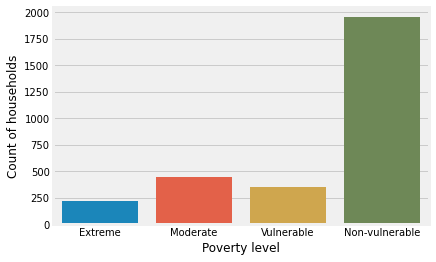

In [ ]:
sns.countplot(imputed_cleaned_encoded_data_v1_df.loc[imputed_cleaned_encoded_data_v1_df['parentesco1']==1, 'Target'])
plt.xticks(ticks=[0, 1, 2, 3], labels=['Extreme', 'Moderate', 'Vulnerable', 'Non-vulnerable'])
plt.xlabel('Poverty level')
plt.ylabel('Count of households')


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


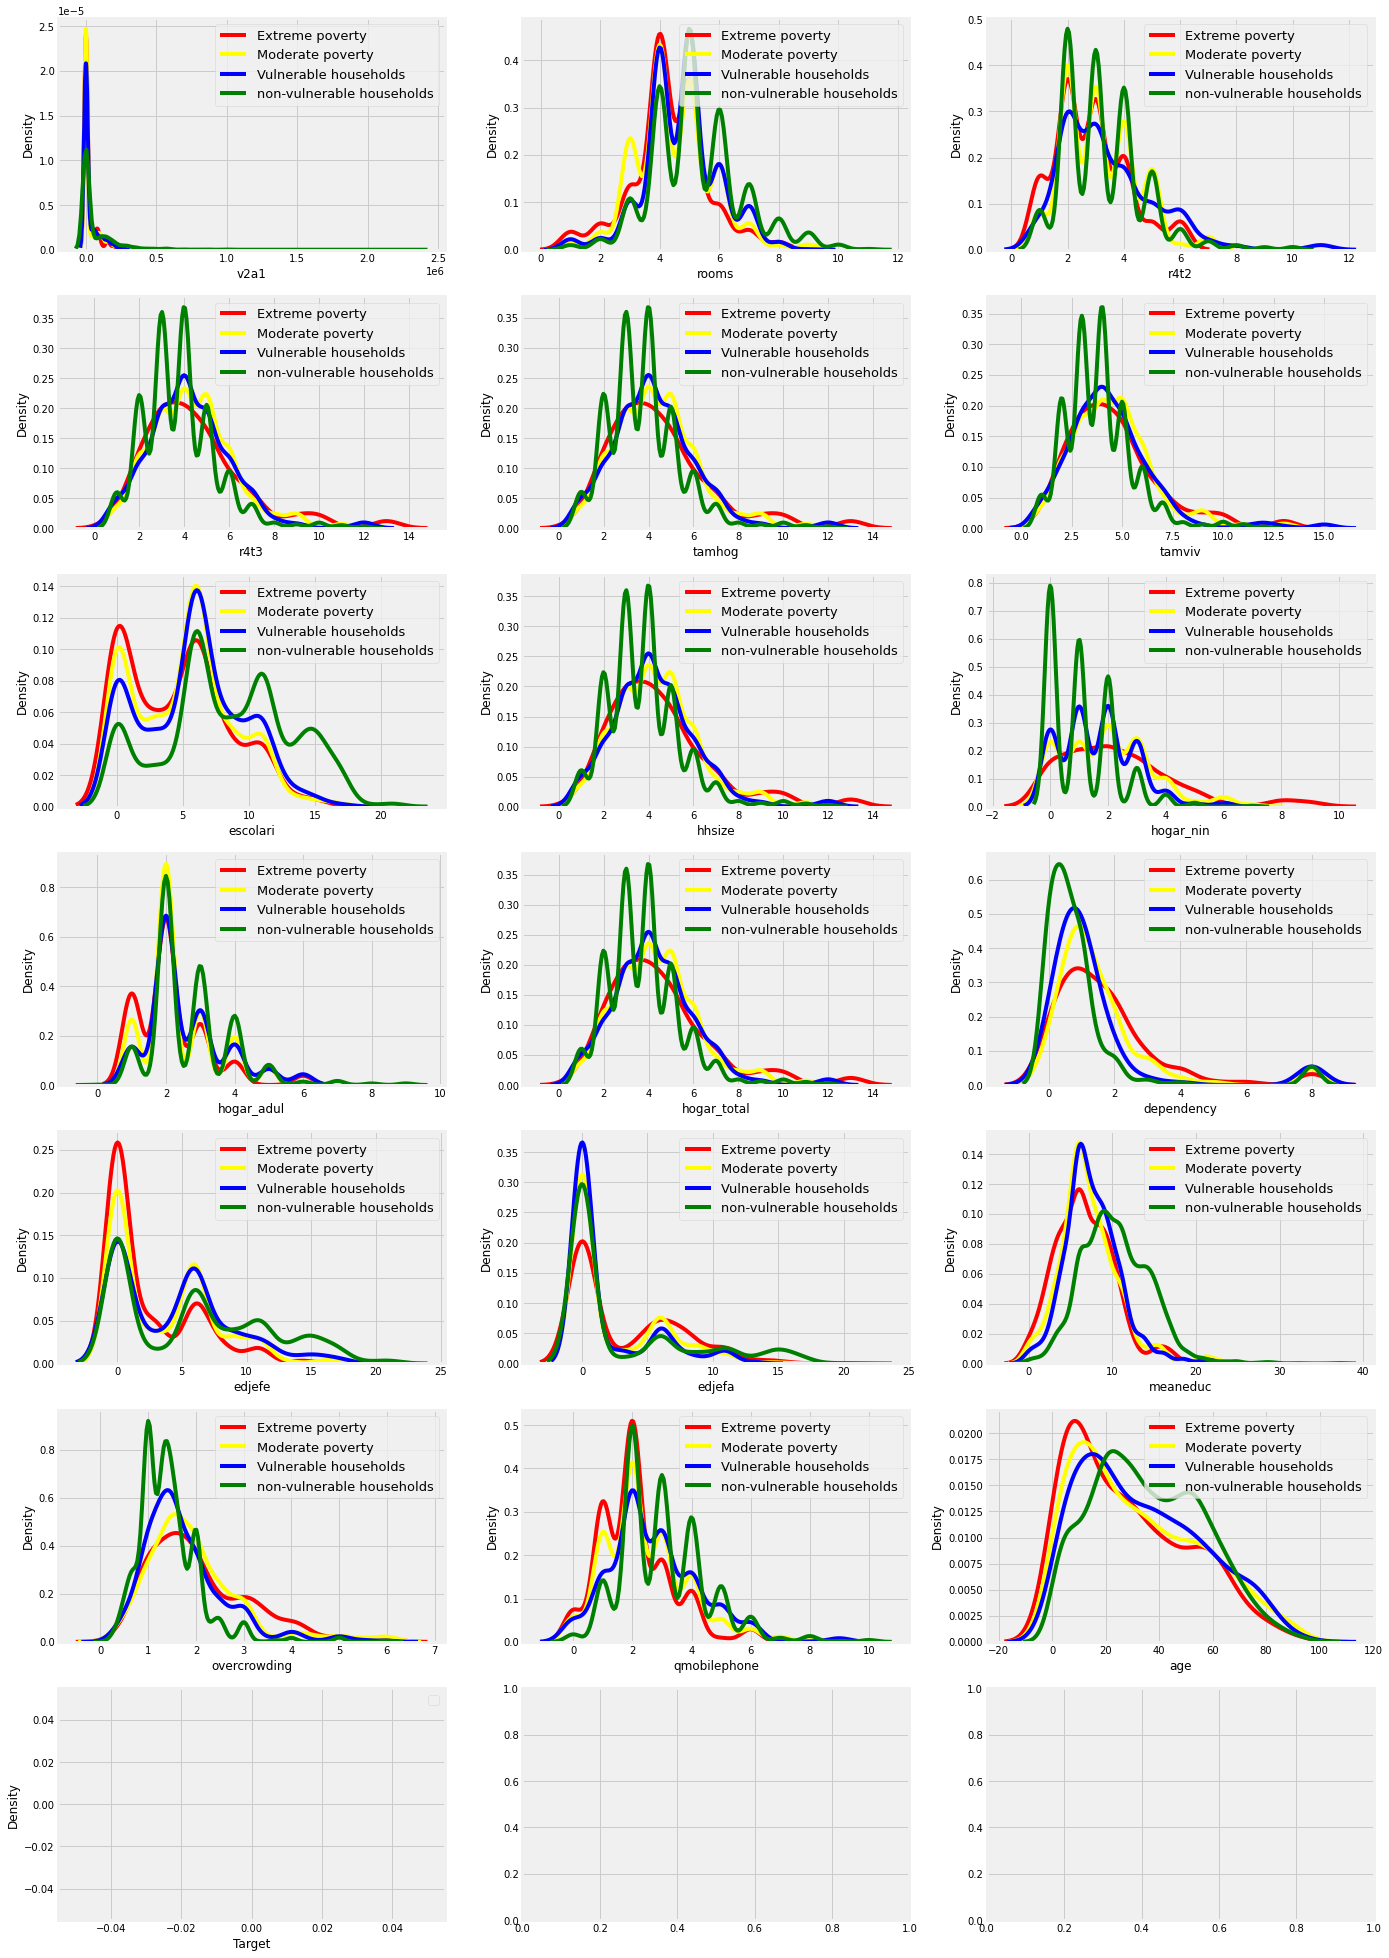

In [ ]:
# Get column names to plot
column_names_to_plot_list = []
for column_name in imputed_cleaned_encoded_data_v1_df.select_dtypes(exclude='object').columns:
    if (imputed_cleaned_encoded_data_v1_df[column_name].nunique()>=10 and imputed_cleaned_encoded_data_v1_df[column_name].std()!=0 and 'SQ' not in column_name.upper()) or column_name=='Target':
        column_names_to_plot_list.append(column_name)

# Set mapping dictionary
mapping_dict = {
    1: ['red', 'Extreme poverty'],
    2: ['yellow', 'Moderate poverty'],
    3: ['blue', 'Vulnerable households'],
    4: ['green', 'non-vulnerable households']
}


# Set number of columns and rows for subplots axes in figure
n_cols = 3
n_rows = math.ceil(len(column_names_to_plot_list) / n_cols)

# Create figure and subplots axes array
figure, axes_array = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*7, n_rows*5))

# Set target column name
target_column_name = 'Target'

# Initilize axes array indices for the loop
i = 0 # Row index
j = 0 # Column index

# Loop for plotting
for current_column_name in column_names_to_plot_list:
    for key, values_list in mapping_dict.items():
        # Get current target level
        current_target_level = key

        # Get current color
        current_color = mapping_dict[key][0]

        # Get current label
        current_label = mapping_dict[key][1]

        # Get data in the current column cirresoibdubg to cyrrebt target kevek
        current_data_to_plot_list = imputed_cleaned_encoded_data_v1_df.loc[imputed_cleaned_encoded_data_v1_df[target_column_name]==current_target_level, current_column_name]

        # Plot 
        sns.kdeplot(x=current_data_to_plot_list, color=current_color, label=current_label, ax=axes_array[i][j])
        
    
    # Plot customization
    axes_array[i][j].legend(fontsize=13)


    
    # Update the subplots axes indices
    j += 1
    if j == n_cols:
        j = 0 # Reset column index for the next row
        i += 1 # Go to next row 
    

Observations:
1. Possible useful variable which are indicative of target classes: 'rooms', 'escolari', 'dependency', 'edgefe', 'meaneduc' 'overcrowding'

### Box plots

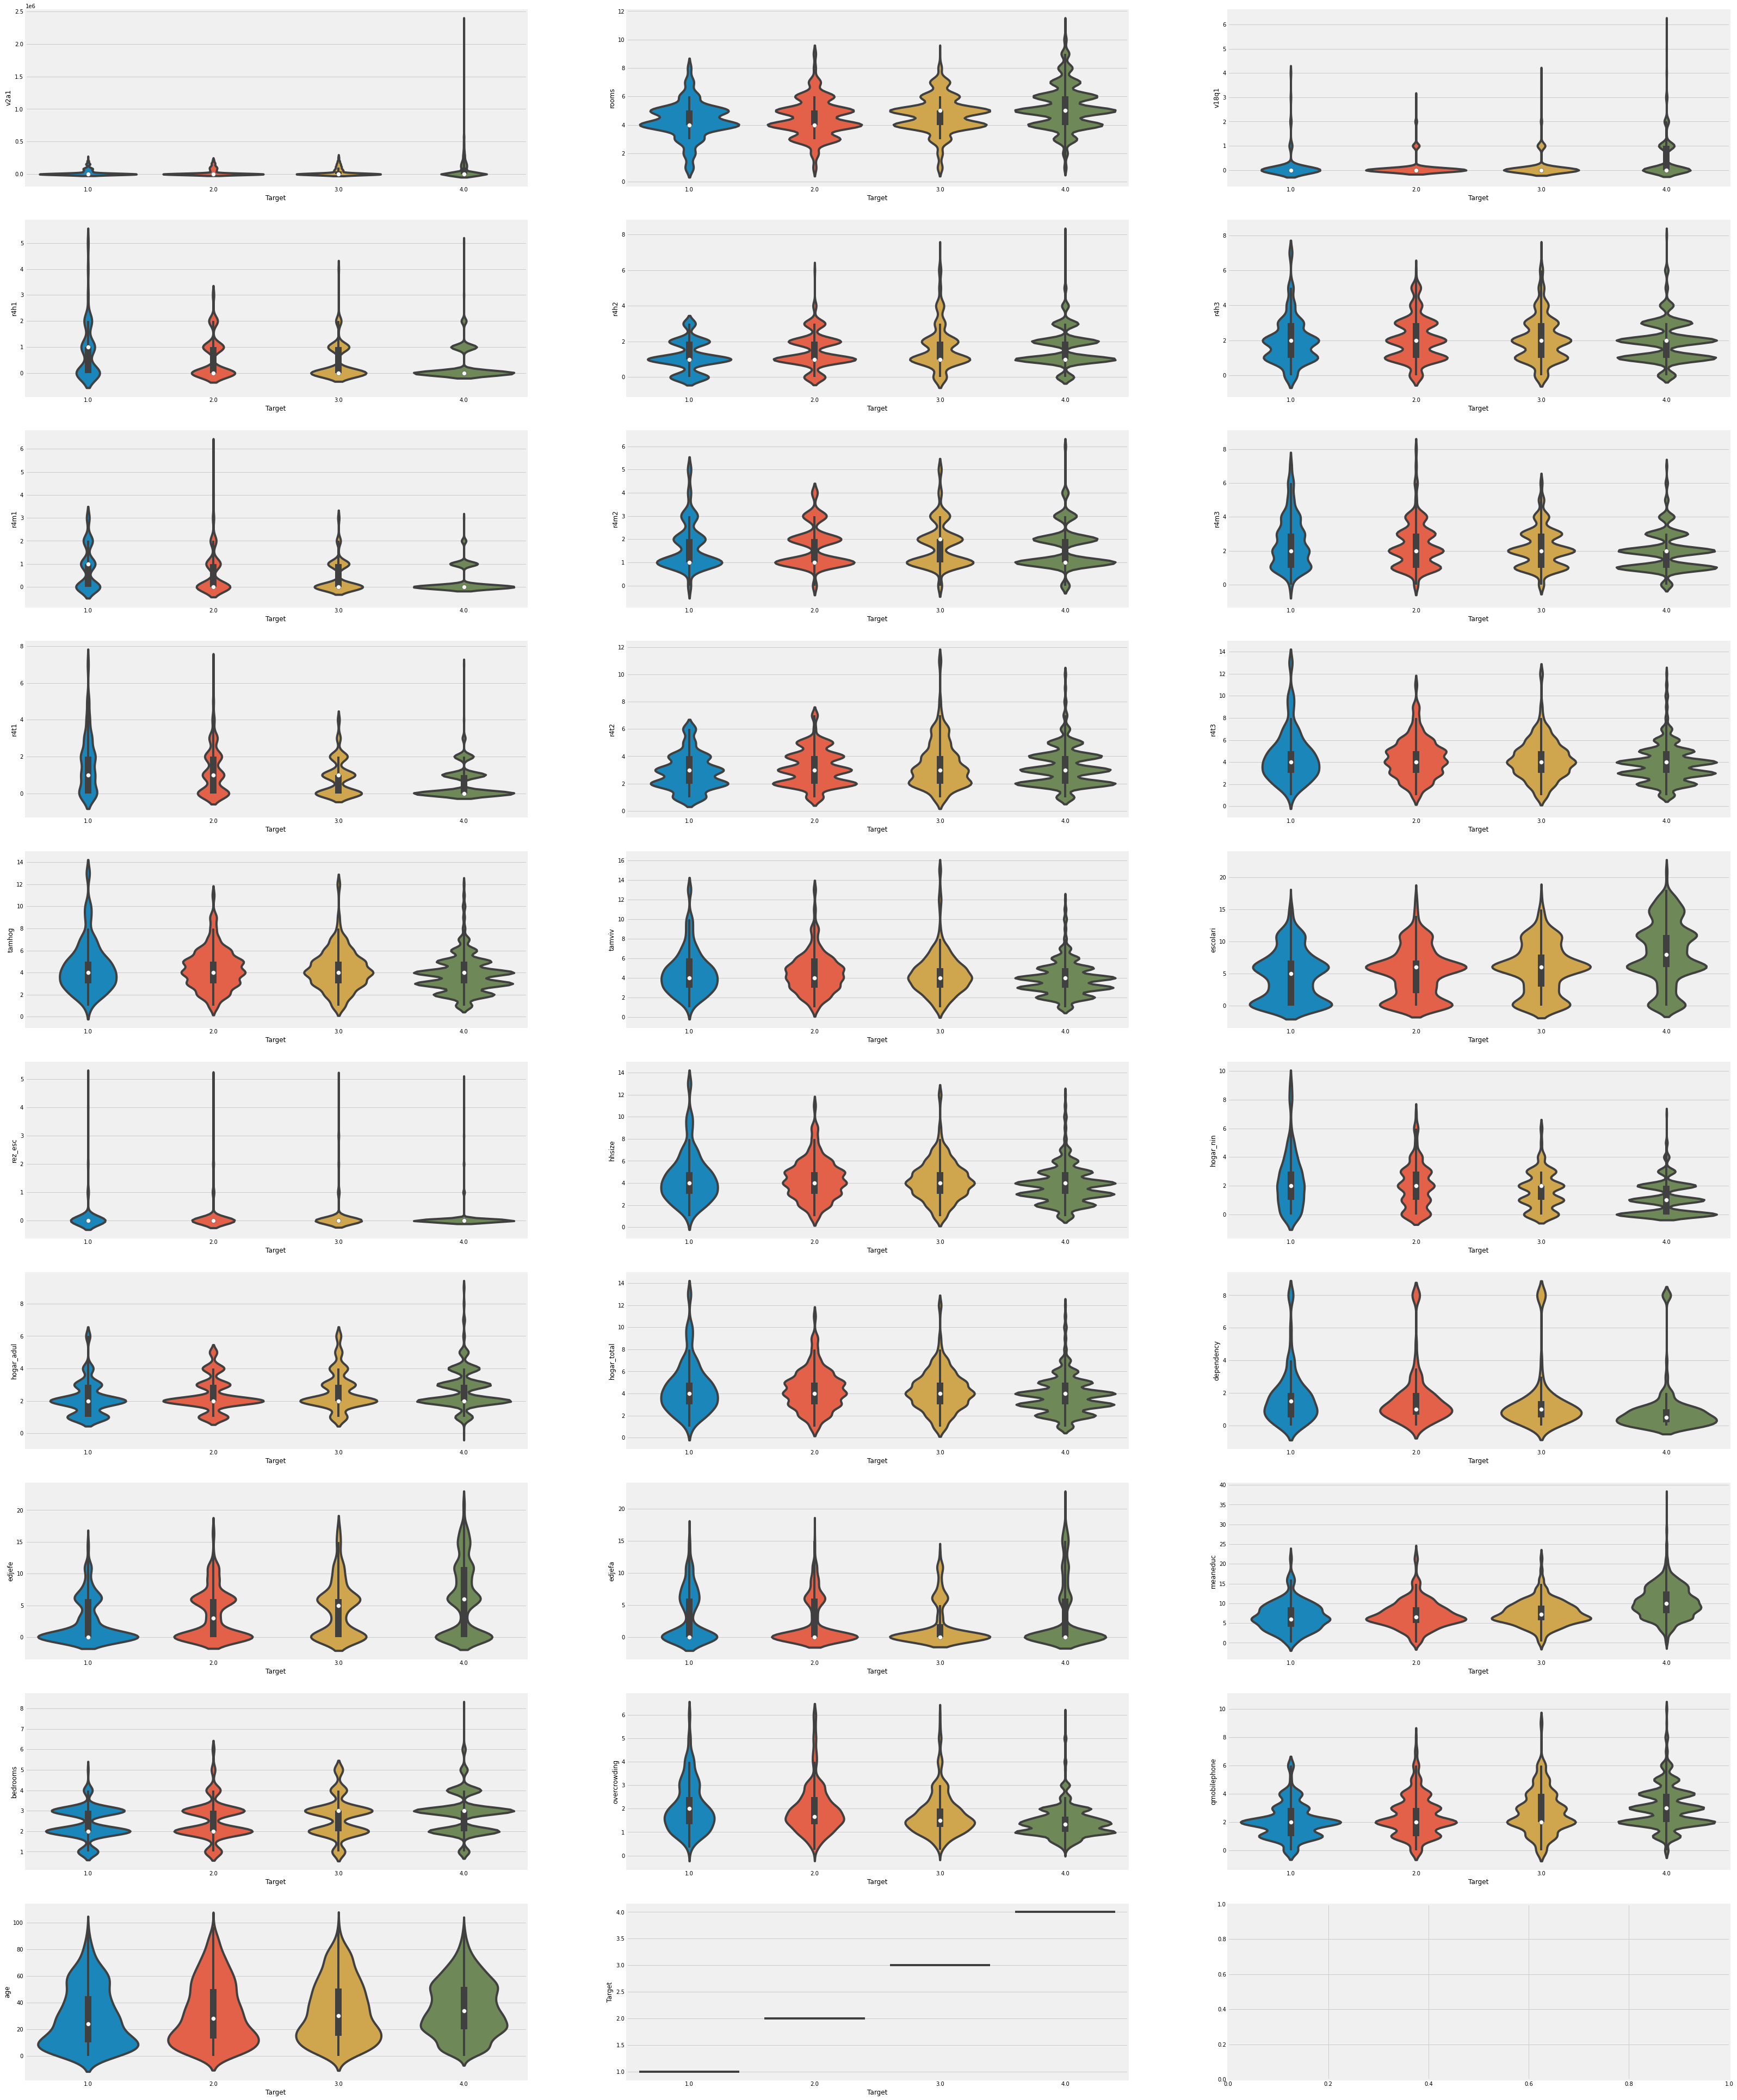

In [ ]:
# Get column names to plot
column_names_to_plot_list = []
for column_name in imputed_cleaned_encoded_data_v1_df.select_dtypes(exclude='object').columns:
    if (imputed_cleaned_encoded_data_v1_df[column_name].nunique()>=5 and 'SQ' not in column_name.upper()) or column_name=='Target':
        column_names_to_plot_list.append(column_name)

# Create figure and axes array of subplots\
n_cols = 3
n_rows = math.ceil(len(column_names_to_plot_list) / n_cols)
figure, axes_array = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_rows*5, n_rows*7))

# Initialize row and column indices of subplots
i = 0 # Row index
j = 0 # Column index

# Loop over the columns to plot
for column_name in column_names_to_plot_list:
    sns.violinplot(data=imputed_cleaned_encoded_data_v1_df, x='Target', y=column_name, ax=axes_array[i][j])

    # Increment/reset subplots indices
    j += 1 # Increment column index
    if j == 3:
        j = 0 # Reset column index
        i += 1 # Increment row index
    

Observations:
1. Variables with different spread for different target class are possibly useful.

### lmplots

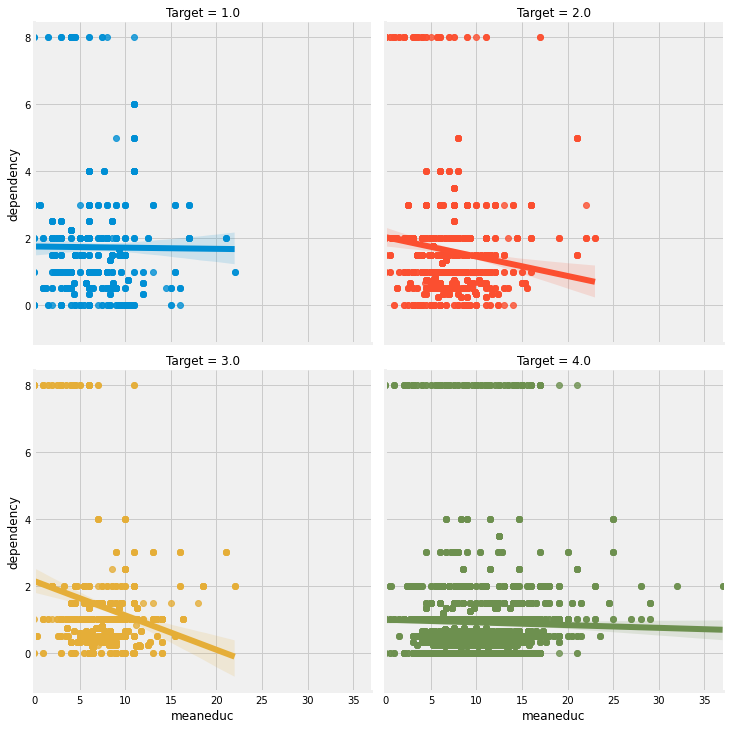

In [ ]:
sns.lmplot(data=imputed_cleaned_encoded_data_v1_df, x='meaneduc', y='dependency', col='Target', hue='Target', col_wrap=2)

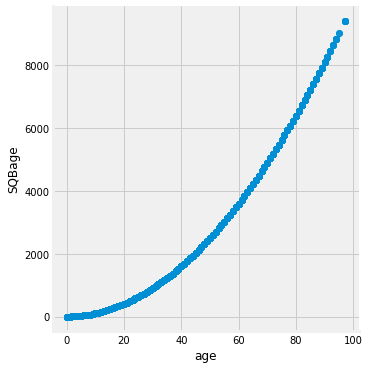

In [ ]:
sns.lmplot(data=imputed_cleaned_encoded_data_v1_df, y='SQBage', x='age', fit_reg=False)

# Feature engineering

## Make sets of features

Lets make set of variables as follows based on domain knowledge and data descriptions given with the data:
1. Id variables
2. Squared varaibles
3. Household variables
4. Individual variables

We have already added id and squared variables in columns to drop dictionary

We can also further categorize the variables as boolean, discrete, continuous, ordinal or nominal. But as the data is already encoded, its not required here.

### Id and squared variables

In [ ]:
pprint(column_names_sets_dict)

OrderedDict([('Id columns', ['Id', 'idhogar']),
             ('Squared variables',
              {'SQBage',
               'SQBdependency',
               'SQBedjefe',
               'SQBescolari',
               'SQBhogar_nin',
               'SQBhogar_total',
               'SQBmeaned',
               'SQBovercrowding',
               'agesq'})])


### Individual variables

instlevel7  instlevel1  estadocivil7  parentesco7  parentesco8  v18q  \
0              0           0             0            0            0     0   
1              0           0             0            0            0     1   
2              0           0             0            0            0     0   
3              0           0             1            0            0     1   
4              0           0             0            0            0     1   
...          ...         ...           ...          ...          ...   ...   
9552           0           0             0            0            0     0   
9553           0           1             0            0            0     0   
9554           0           0             0            0            0     0   
9555           0           0             1            0            0     0   
9556           0           0             1            0            0     0   

      parentesco9  female  age  parentesco10  estadocivil5  instlevel4  \
0               0       0   43             0             0           1   
1               0       0   67             0             0           0   
2               0       1   92             0             0           0   
3               0       0   17             0             0           1   
4               0       1   37             0             0           0   
...           ...     ...  ...           ...           ...         ...   
9552            0       0   46             0             0           1   
9553            0       1    2             0             0           0   
9554            0       1   50             0             0           0   
9555            0       1   26             0             0           0   
9556            0       0   21             0             0           1   

      parentesco11  instlevel5  mobilephone  parentesco12  parentesco6  \
0                0           0            1             0            0   
1                0           0            1             0            0   
2                0           1            0             0            0   
3                0           0            1             0            0   
4                0           1            1             0            0   
...            ...         ...          ...           ...          ...   
9552             0           0            1             0            0   
9553             0           0            1             0            0   
9554             0           0            1             0            0   
9555             0           1            1             0            0   
9556             0           0            1             0            0   

      estadocivil4  instlevel3  estadocivil1  escolari  parentesco3  \
0                1           0             0        10            0   
1                1           0             0        12            0   
2                0           0             0        11            0   
3                0           0             0         9            1   
4                0           0             0        11            0   
...            ...         ...           ...       ...          ...   
9552             0           0             0         9            0   
9553             0           0             1         0            1   
9554             0           0             0         5            0   
9555             0           0             0        11            1   
9556             0           0             0         8            1   

      estadocivil6  instlevel8  parentesco4  estadocivil2  parentesco1  \
0                0           0            0             0            1   
1                0           1            0             0            1   
2                1           0            0             0            1   
3                0           0            0             0            0   
4                0           0            0             1           

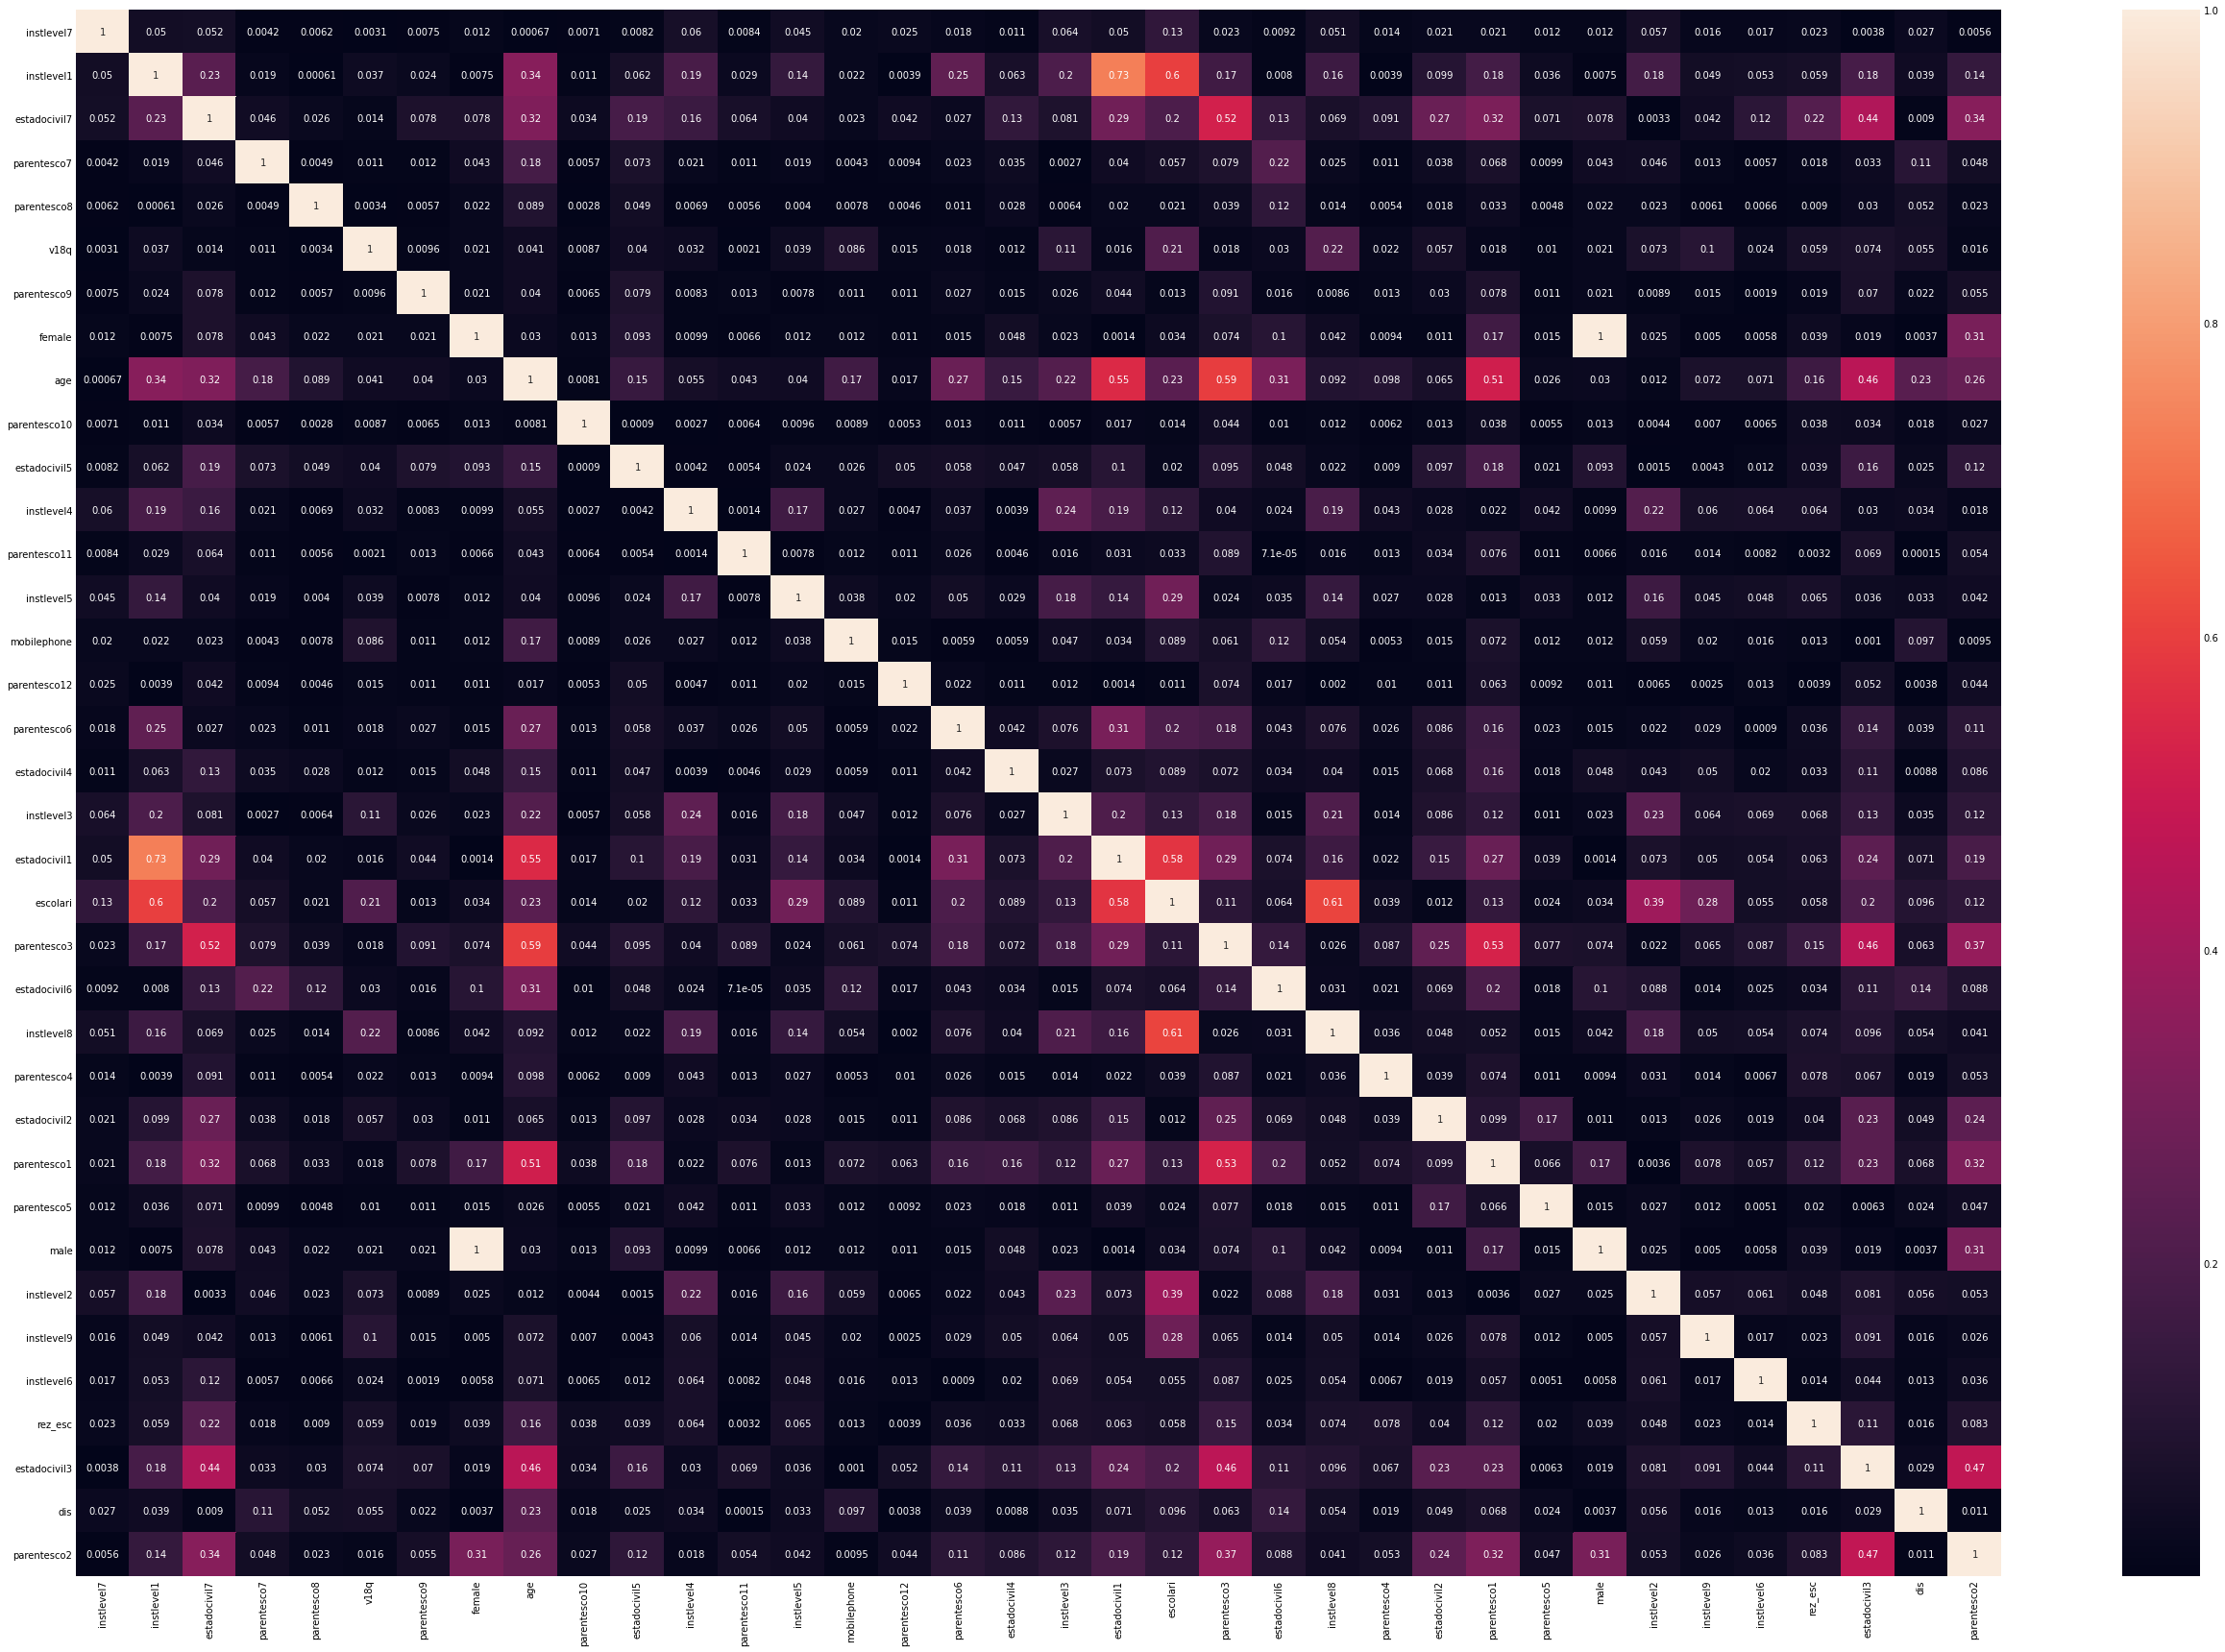

In [ ]:
# Individual columns
column_names_sets_dict['Individual columns'] = set(['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc', 'escolari', 'age'])

# Get the data available on the individual level
individuals_data_df = imputed_cleaned_encoded_data_v1_df[column_names_sets_dict['Individual columns']]

# Display
display(individuals_data_df)

# Absolute correlation heatmap
plt.figure(figsize=(40,30))
sns.heatmap(abs(individuals_data_df.corr()), annot=True)

#### Aggregate individuals data

We will aggregate individuals data to household level using the following functions:
1. min
2. max
3. sum
4. count
5. std
6. range_function (custom function)

In [ ]:
# Define custom range function
range_function = lambda x: x.max() - x.min()
range_function.__name__ = 'range_' # Nmae of the fuction

# Group and aggregate the individuals data to household level
aggregated_individuals_data_df = imputed_cleaned_encoded_data_v1_df.groupby('idhogar')[list(column_names_sets_dict['Individual columns'])].agg(['mean', 'min', 'max', 'count', 'std', range_function])

# Display aggregated data
aggregated_individuals_data_df

instlevel7                           instlevel1                \
                mean min max count  std range_       mean min max count   
idhogar                                                                   
001ff74ca       0.00   0   0     2  0.0      0   0.500000   0   1     2   
003123ec2       0.00   0   0     4  0.0      0   0.500000   0   1     4   
004616164       0.00   0   0     2  0.0      0   0.000000   0   0     2   
004983866       0.00   0   0     2  0.0      0   0.000000   0   0     2   
005905417       0.00   0   0     3  0.0      0   0.333333   0   1     3   
...              ...  ..  ..   ...  ...    ...        ...  ..  ..   ...   
ff9343a35       0.00   0   0     4  0.0      0   0.000000   0   0     4   
ff9d5ab17       0.00   0   0     3  0.0      0   0.333333   0   1     3   
ffae4a097       0.00   0   0     2  0.0      0   0.000000   0   0     2   
ffe90d46f       0.00   0   0     4  0.0      0   0.000000   0   0     4   
fff7d6be1       0.25   0   1     4  0.5      1   0.000000   0   0     4   

                           estadocivil7                                 \
                std range_         mean min max count       std range_   
idhogar                                                                  
001ff74ca  0.707107      1     0.000000   0   0     2  0.000000      0   
003123ec2  0.577350      1     0.000000   0   0     4  0.000000      0   
004616164  0.000000      0     0.500000   0   1     2  0.707107      1   
004983866  0.000000      0     0.500000   0   1     2  0.707107      1   
005905417  0.577350      1     0.333333   0   1     3  0.577350      1   
...             ...    ...          ...  ..  ..   ...       ...    ...   
ff9343a35  0.000000      0     0.500000   0   1     4  0.577350      1   
ff9d5ab17  0.577350      1     0.000000   0   0     3  0.000000      0   
ffae4a097  0.000000      0     0.000000   0   0     2  0.000000      0   
ffe90d46f  0.000000      0     0.250000   0   1     4  0.500000      1   
fff7d6be1  0.000000      0     0.750000   0   1     4  0.500000      1   

          parentesco7                           parentesco8                \
                 mean min max count  std range_        mean min max count   
idhogar                                                                     
001ff74ca         0.0   0   0     2  0.0      0         0.0   0   0     2   
003123ec2         0.0   0   0     4  0.0      0         0.0   0   0     4   
004616164         0.0   0   0     2  0.0      0         0.0   0   0     2   
004983866         0.0   0   0     2  0.0      0         0.0   0   0     2   
005905417         0.0   0   0     3  0.0      0         0.0   0   0     3   
...               ...  ..  ..   ...  ...    ...         ...  ..  ..   ...   
ff9343a35         0.0   0   0     4  0.0      0         0.0   0   0     4   
ff9d5ab17         0.0   0   0     3  0.0      0         0.0   0   0     3   
ffae4a097         0.0   0   0     2  0.0      0         0.0   0   0     2   
ffe90d46f         0.0   0   0     4  0.0      0         0.0   0   0     4   
fff7d6be1         0.0   0   0     4  0.0      0         0.0   0   0     4   

                      v18q                           parentesco9          \
           std range_ mean min max count  std range_        mean min max   
idhogar                                                                    
001ff74ca  0.0      0    1   1   1     2  0.0      0         0.0   0   0   
003123ec2  0.0      0    0   0   0     4  0.0      0         0.0   0   0   
004616164  0.0      0    0   0   0     2  0.0      0         0.0   0   0   
004983866  0.0      0    0   0   0     2  0.0      0         0.0   0   0   
005905417  0.0      0    0   0   0     3  0.0      0         0.0   0   0   
...        ...    ...  ...  ..  ..   ...  ...    ...         ...  ..  ..   
ff9343a35  0.0      0    1   1   1     4  0.0      0         0.0   0   0   
ff9d5ab17  0.0      0    0   0   0     3  0.0      0         0.0   0   0   
ffae4a0

In [ ]:
# Merge the 2 levels of columns

# Initiate a list to store the merged column names
merged_column_names_list = []

# Get the list of merged column names
for level_0_column_name in aggregated_individuals_data_df.columns.levels[0]:
    for level_1_column_name in aggregated_individuals_data_df.columns.levels[1]:
        merged_column_names_list.append(level_0_column_name+'-'+level_1_column_name)

# Change the column names
aggregated_individuals_data_df.columns = merged_column_names_list

# Dusokay
aggregated_individuals_data_df

instlevel7-mean  instlevel7-min  instlevel7-max  instlevel7-count  \
idhogar                                                                        
001ff74ca             0.00               0               0                 2   
003123ec2             0.00               0               0                 4   
004616164             0.00               0               0                 2   
004983866             0.00               0               0                 2   
005905417             0.00               0               0                 3   
...                    ...             ...             ...               ...   
ff9343a35             0.00               0               0                 4   
ff9d5ab17             0.00               0               0                 3   
ffae4a097             0.00               0               0                 2   
ffe90d46f             0.00               0               0                 4   
fff7d6be1             0.25               0               1                 4   

           instlevel7-std  instlevel7-range_  instlevel1-mean  instlevel1-min  \
idhogar                                                                         
001ff74ca             0.0                  0         0.500000               0   
003123ec2             0.0                  0         0.500000               0   
004616164             0.0                  0         0.000000               0   
004983866             0.0                  0         0.000000               0   
005905417             0.0                  0         0.333333               0   
...                   ...                ...              ...             ...   
ff9343a35             0.0                  0         0.000000               0   
ff9d5ab17             0.0                  0         0.333333               0   
ffae4a097             0.0                  0         0.000000               0   
ffe90d46f             0.0                  0         0.000000               0   
fff7d6be1             0.5                  1         0.000000               0   

           instlevel1-max  instlevel1-count  instlevel1-std  \
idhogar                                                       
001ff74ca               1                 2        0.707107   
003123ec2               1                 4        0.577350   
004616164               0                 2        0.000000   
004983866               0                 2        0.000000   
005905417               1                 3        0.577350   
...                   ...               ...             ...   
ff9343a35               0                 4        0.000000   
ff9d5ab17               1                 3        0.577350   
ffae4a097               0                 2        0.000000   
ffe90d46f               0                 4        0.000000   
fff7d6be1               0                 4        0.000000   

           instlevel1-range_  estadocivil7-mean  estadocivil7-min  \
idhogar                                                             
001ff74ca                  1           0.000000                 0   
003123ec2                  1           0.000000                 0   
004616164                  0           0.500000                 0   
004983866                  0           0.500000                 0   
005905417                  1           0.333333                 0   
...                      ...                ...               ...   
ff9343a35                  0           0.500000                 0   
ff9d5ab17                  1           0.000000                 0   
ffae4a097                  0           0.000000                 0   
ffe90d46f                  0           0.250000                 0   
fff7d6be1                  0           0.750000                 0   

           estadocivil7-max  estadocivil7-count  estadocivil7-std  \
idhogar                                                             
001ff74ca                 0                   2          0.0

#### Correlated individual varaibles

In [ ]:
# Calculate correlation matrix
aggregated_individuals_correlation_matrix_df = aggregated_individuals_data_df.corr()

# Set max allowed correlation
max_allowed_absolute_correlation = 0.95

# Initialize the set to store correlated individual variables
column_names_sets_dict['Correlated aggregated individual variables'] = set()

# Get correlated variables
for i, diagonal_column_name in enumerate(aggregated_individuals_data_df.columns):
    for j, left_column_name in enumerate(aggregated_individuals_data_df.columns):
        if j >= i: # Condition to skip checking duplicates.
            continue
        elif abs(aggregated_individuals_correlation_matrix_df.iloc[i, j]) > max_allowed_absolute_correlation:
            # print(f'Absolute correlation between {diagonal_column_name} and {left_column_name} is {abs(aggregated_individuals_correlation_matrix_df.iloc[i, j])}.')
            # print(f'    Adding {diagonal_column_name} to correlated variables set')
            column_names_sets_dict['Correlated aggregated individual variables'].add(diagonal_column_name)

# Display 
len(column_names_sets_dict['Correlated aggregated individual variables'])

99

### Household variables

In [ ]:
# Household columns
column_names_sets_dict['Household columns'] = set(['idhogar', 'Target', 'hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone', 'v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding'])

# Get the household level data based on heads of the households
heads_data_df = imputed_cleaned_encoded_data_v1_df.loc[imputed_cleaned_encoded_data_v1_df['parentesco1']==1, column_names_sets_dict['Household columns']]

# Display
heads_data_df

sanitario5  energcocinar1  tipovivi1  tipovivi2  pisocemento  paredzinc  \
0              0              0          0          0            0          0   
1              0              0          0          0            0          0   
2              0              0          1          0            0          0   
5              0              0          0          0            0          0   
8              0              0          0          0            0          0   
...          ...            ...        ...        ...          ...        ...   
9535           0              0          1          0            1          0   
9541           1              0          1          0            0          0   
9545           0              0          0          1            1          0   
9551           0              0          1          0            0          0   
9552           0              0          0          0            1          0   

      pareddes  etecho1  etecho2  coopele  hogar_total  paredmad  lugar6  \
0            0        1        0        0            1         0       0   
1            0        0        1        0            1         1       0   
2            0        0        0        0            1         1       0   
5            0        0        0        0            4         0       0   
8            0        1        0        0            4         0       0   
...        ...      ...      ...      ...          ...       ...     ...   
9535         0        0        1        1            5         0       1   
9541         0        1        0        0            5         1       1   
9545         0        0        1        1            5         1       1   
9551         0        0        0        1            2         0       1   
9552         0        0        1        1            5         0       1   

      television  lugar1  r4h3  r4m2  lugar2  paredother  sanitario3  rooms  \
0              0       1     1     0       0           0           0      3   
1              0       1     1     0       0           0           0      4   
2              0       1     0     1       0           0           0      8   
5              0       1     2     1       0           0           0      5   
8              0       1     1     1       0           0           0      2   
...          ...     ...   ...   ...     ...         ...         ...    ...   
9535           1       0     2     1       0           0           0      4   
9541           0       0     4     1       0           0           0      3   
9545           0       0     3     2       0           0           1      5   
9551           0       0     1     1       0           0           1      3   
9552           1       0     2     2       0           0           1      6   

      v14a  tamhog  pisomoscer  epared1  paredfibras  energcocinar3  \
0        1       1           1        0            0              1   
1        1       1           0        0            0              0   
2        1       1           1        0            0              0   
5        1       4           1        0            0              0   
8        1       4           1        1            0              1   
...    ...     ...         ...      ...          ...            ...   
9535     1       5           0        0            0              0   
9541     0       5           0        0            0              0   
9545     1       5           0        0            0              1   
9551     1       2           1        0            0              1   
9552     1       5           0        0            0              1   

      sanitario6  tipovivi4  cielorazo  hogar_adul  overcrowding  edjefa  \
0              0          0          1           1      1.000000     0.0   
1              0          0          1           1      1.000000     0.0   
2              0          0          1           1      0.500000    11.0   
5             

#### Get correlated household variables

In [ ]:
# Calculate correlation matrix
heads_correlation_matrix_df = heads_data_df.corr()


# Set max allowed correlation
max_allowed_absolute_correlation = 0.95

# Initialize the set to store correlated individual variables
column_names_sets_dict['Correlated household variables'] = set()

# Get correlated variables
for i, diagonal_column_name in enumerate(heads_correlation_matrix_df.columns):
    for j, left_column_name in enumerate(heads_correlation_matrix_df.columns):
        # print(i, j)
        if j >= i: # Condition to skip checking duplicates.
            continue
        elif diagonal_column_name == 'idhogar' or diagonal_column_name == 'Target': # These columns should be kept for merging
            continue
        elif abs(heads_correlation_matrix_df.iloc[i, j]) > max_allowed_absolute_correlation:
            print(f'Absolute correlation between {diagonal_column_name} and {left_column_name} is {abs(heads_correlation_matrix_df.iloc[i, j])}.')
            print(f'    Adding {diagonal_column_name} to correlated variables set')
            column_names_sets_dict['Correlated household variables'].add(diagonal_column_name)

# Display 
column_names_sets_dict['Correlated household variables']

Absolute correlation between tamhog and hogar_total is 1.0.
    Adding tamhog to correlated variables set
Absolute correlation between area1 and area2 is 1.0.
    Adding area1 to correlated variables set
Absolute correlation between hhsize and hogar_total is 1.0.
    Adding hhsize to correlated variables set
Absolute correlation between hhsize and tamhog is 1.0.
    Adding hhsize to correlated variables set
Absolute correlation between public and coopele is 0.9747882460284906.
    Adding public to correlated variables set
Absolute correlation between r4t3 and hogar_total is 0.996884286366295.
    Adding r4t3 to correlated variables set
Absolute correlation between r4t3 and tamhog is 0.996884286366295.
    Adding r4t3 to correlated variables set
Absolute correlation between r4t3 and hhsize is 0.996884286366295.
    Adding r4t3 to correlated variables set


{'area1', 'hhsize', 'public', 'r4t3', 'tamhog'}

## Feature elimination

### Remove correlated aggregated individual varaibles and merge with heads data

In [ ]:
# Drop the correlated aggregated individual variables
reduced_aggregated_individuals_data_v1_df = aggregated_individuals_data_df.drop(columns=column_names_sets_dict['Correlated aggregated individual variables'],
                                                                                inplace=False)

# Display
reduced_aggregated_individuals_data_v1_df

instlevel7-mean  instlevel7-min  instlevel7-max  instlevel7-count  \
idhogar                                                                        
001ff74ca             0.00               0               0                 2   
003123ec2             0.00               0               0                 4   
004616164             0.00               0               0                 2   
004983866             0.00               0               0                 2   
005905417             0.00               0               0                 3   
...                    ...             ...             ...               ...   
ff9343a35             0.00               0               0                 4   
ff9d5ab17             0.00               0               0                 3   
ffae4a097             0.00               0               0                 2   
ffe90d46f             0.00               0               0                 4   
fff7d6be1             0.25               0               1                 4   

           instlevel1-mean  instlevel1-min  instlevel1-max  estadocivil7-mean  \
idhogar                                                                         
001ff74ca         0.500000               0               1           0.000000   
003123ec2         0.500000               0               1           0.000000   
004616164         0.000000               0               0           0.500000   
004983866         0.000000               0               0           0.500000   
005905417         0.333333               0               1           0.333333   
...                    ...             ...             ...                ...   
ff9343a35         0.000000               0               0           0.500000   
ff9d5ab17         0.333333               0               1           0.000000   
ffae4a097         0.000000               0               0           0.000000   
ffe90d46f         0.000000               0               0           0.250000   
fff7d6be1         0.000000               0               0           0.750000   

           estadocivil7-min  estadocivil7-max  estadocivil7-std  \
idhogar                                                           
001ff74ca                 0                 0          0.000000   
003123ec2                 0                 0          0.000000   
004616164                 0                 1          0.707107   
004983866                 0                 1          0.707107   
005905417                 0                 1          0.577350   
...                     ...               ...               ...   
ff9343a35                 0                 1          0.577350   
ff9d5ab17                 0                 0          0.000000   
ffae4a097                 0                 0          0.000000   
ffe90d46f                 0                 1          0.500000   
fff7d6be1                 0                 1          0.500000   

           parentesco7-mean  parentesco7-min  parentesco7-max  \
idhogar                                                         
001ff74ca               0.0                0                0   
003123ec2               0.0                0                0   
004616164               0.0                0                0   
004983866               0.0                0                0   
005905417               0.0                0                0   
...                     ...              ...              ...   
ff9343a35               0.0                0                0   
ff9d5ab17               0.0                0                0   
ffae4a097               0.0                0                0   
ffe90d46f               0.0                0                0   
fff7d6be1               0.0                0                0   

           parentesco8-mean  parentesco8-min  v18q-mean  v18q-std  \
idhogar                                                             
001ff74ca               0.0                0          1     

In [ ]:
# Removed correlated household variables from heads data
reduced_heads_data_v1_df = heads_data_df.drop(columns=column_names_sets_dict['Correlated household variables'], inplace=False)

# Display
reduced_heads_data_v1_df

sanitario5  energcocinar1  tipovivi1  tipovivi2  pisocemento  paredzinc  \
0              0              0          0          0            0          0   
1              0              0          0          0            0          0   
2              0              0          1          0            0          0   
5              0              0          0          0            0          0   
8              0              0          0          0            0          0   
...          ...            ...        ...        ...          ...        ...   
9535           0              0          1          0            1          0   
9541           1              0          1          0            0          0   
9545           0              0          0          1            1          0   
9551           0              0          1          0            0          0   
9552           0              0          0          0            1          0   

      pareddes  etecho1  etecho2  coopele  hogar_total  paredmad  lugar6  \
0            0        1        0        0            1         0       0   
1            0        0        1        0            1         1       0   
2            0        0        0        0            1         1       0   
5            0        0        0        0            4         0       0   
8            0        1        0        0            4         0       0   
...        ...      ...      ...      ...          ...       ...     ...   
9535         0        0        1        1            5         0       1   
9541         0        1        0        0            5         1       1   
9545         0        0        1        1            5         1       1   
9551         0        0        0        1            2         0       1   
9552         0        0        1        1            5         0       1   

      television  lugar1  r4h3  r4m2  lugar2  paredother  sanitario3  rooms  \
0              0       1     1     0       0           0           0      3   
1              0       1     1     0       0           0           0      4   
2              0       1     0     1       0           0           0      8   
5              0       1     2     1       0           0           0      5   
8              0       1     1     1       0           0           0      2   
...          ...     ...   ...   ...     ...         ...         ...    ...   
9535           1       0     2     1       0           0           0      4   
9541           0       0     4     1       0           0           0      3   
9545           0       0     3     2       0           0           1      5   
9551           0       0     1     1       0           0           1      3   
9552           1       0     2     2       0           0           1      6   

      v14a  pisomoscer  epared1  paredfibras  energcocinar3  sanitario6  \
0        1           1        0            0              1           0   
1        1           0        0            0              0           0   
2        1           1        0            0              0           0   
5        1           1        0            0              0           0   
8        1           1        1            0              1           0   
...    ...         ...      ...          ...            ...         ...   
9535     1           0        0            0              0           0   
9541     0           0        0            0              0           0   
9545     1           0        0            0              1           0   
9551     1           1        0            0              1           0   
9552     1           0        0            0              1           0   

      tipovivi4  cielorazo  hogar_adul  overcrowding  edjefa  hacapo  eviv1  \
0             0          1           1      1.000000     0.0       0      1   
1             0          1           1      1.000000     0.0       0      0   
2             0          1       

In [ ]:
# Merge aggregated individuals and heads data ('idhogar' column is added to merge on)
merged_heads_data_df = pd.merge(left=reduced_heads_data_v1_df, 
                                right=reduced_aggregated_individuals_data_v1_df,
                                on='idhogar', how='left')

# Display
merged_heads_data_df

sanitario5  energcocinar1  tipovivi1  tipovivi2  pisocemento  paredzinc  \
0              0              0          0          0            0          0   
1              0              0          0          0            0          0   
2              0              0          1          0            0          0   
3              0              0          0          0            0          0   
4              0              0          0          0            0          0   
...          ...            ...        ...        ...          ...        ...   
2968           0              0          1          0            1          0   
2969           1              0          1          0            0          0   
2970           0              0          0          1            1          0   
2971           0              0          1          0            0          0   
2972           0              0          0          0            1          0   

      pareddes  etecho1  etecho2  coopele  hogar_total  paredmad  lugar6  \
0            0        1        0        0            1         0       0   
1            0        0        1        0            1         1       0   
2            0        0        0        0            1         1       0   
3            0        0        0        0            4         0       0   
4            0        1        0        0            4         0       0   
...        ...      ...      ...      ...          ...       ...     ...   
2968         0        0        1        1            5         0       1   
2969         0        1        0        0            5         1       1   
2970         0        0        1        1            5         1       1   
2971         0        0        0        1            2         0       1   
2972         0        0        1        1            5         0       1   

      television  lugar1  r4h3  r4m2  lugar2  paredother  sanitario3  rooms  \
0              0       1     1     0       0           0           0      3   
1              0       1     1     0       0           0           0      4   
2              0       1     0     1       0           0           0      8   
3              0       1     2     1       0           0           0      5   
4              0       1     1     1       0           0           0      2   
...          ...     ...   ...   ...     ...         ...         ...    ...   
2968           1       0     2     1       0           0           0      4   
2969           0       0     4     1       0           0           0      3   
2970           0       0     3     2       0           0           1      5   
2971           0       0     1     1       0           0           1      3   
2972           1       0     2     2       0           0           1      6   

      v14a  pisomoscer  epared1  paredfibras  energcocinar3  sanitario6  \
0        1           1        0            0              1           0   
1        1           0        0            0              0           0   
2        1           1        0            0              0           0   
3        1           1        0            0              0           0   
4        1           1        1            0              1           0   
...    ...         ...      ...          ...            ...         ...   
2968     1           0        0            0              0           0   
2969     0           0        0            0              0           0   
2970     1           0        0            0              1           0   
2971     1           1        0            0              1           0   
2972     1           0        0            0              1           0   

      tipovivi4  cielorazo  hogar_adul  overcrowding  edjefa  hacapo  eviv1  \
0             0          1           1      1.000000     0.0       0      1   
1             0          1           1      1.000000     0.0       0      0   
2             0          1       

# Data preprocessing 

## Train test split

In [ ]:
# Split data into train and test
X_train_df, X_test_df, y_train_series, y_test_series = train_test_split(merged_heads_data_df.drop(columns=['idhogar', 'Target'], inplace=False), 
                                                                        merged_heads_data_df['Target'], random_state=7, test_size=0.15)

# Display shapes
display(X_train_df.describe().mean(axis=1))
print(X_train_df.shape)
display(X_test_df.describe().mean(axis=1))
print(X_test_df.shape)
print(y_train_series.shape)
print(y_test_series.shape)

count     2506.347826
mean       254.322058
std        576.019191
min          0.168246
25%          0.724796
50%          1.218772
75%        315.814064
max      11373.909661
dtype: float64

(2527, 207)


count     442.695652
mean      229.392242
std       533.478326
min         0.164493
25%         0.731981
50%         1.197689
75%       194.997323
max      4138.344400
dtype: float64

(446, 207)
(2527,)
(446,)


## Imputation

In [ ]:
# Create model instance
iterative_imputer_model = IterativeImputer(random_state=7)

# Fit model on train data
fitted_iterative_imputer_model = iterative_imputer_model.fit(X_train_df)

# Save fitted imputer model
save_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_iterative_imputer_model.joblib'
dump(fitted_iterative_imputer_model, save_path)

['/content/drive/MyDrive/EE 769/Project/Stored data/fitted_iterative_imputer_model.joblib']

In [ ]:
# Load fitted imputer model
saved_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_iterative_imputer_model.joblib'
fitted_iterative_imputer_model = load(saved_path)

# Impute train data
imputed_X_train_array = fitted_iterative_imputer_model.transform(X_train_df)

# Convert to dataframe
imputed_X_train_df = pd.DataFrame(imputed_X_train_array, columns=X_train_df.columns, index=X_train_df.index)

# Display
display(imputed_X_train_df.describe().mean(axis=1))

# Transform test data
imputed_X_test_array = fitted_iterative_imputer_model.transform(X_test_df)

# Convert to dataframe
imputed_X_test_df = pd.DataFrame(imputed_X_test_array, columns=X_test_df.columns, index=X_test_df.index)

# Display
display(imputed_X_test_df.describe().mean(axis=1))

count     2527.000000
mean       278.531728
std        553.212669
min          0.167656
25%          0.725171
50%          1.214007
75%        458.668410
max      11373.909661
dtype: float64

count     446.000000
mean      255.731975
std       511.436869
min         0.163957
25%         0.732594
50%         1.193505
75%       404.141585
max      4138.344400
dtype: float64

## Scale the data

Note:
Tree based models do not require scaling.

In [ ]:
# Create model instance
standard_scaler_model = StandardScaler()

# Fit on train data
fitted_standard_scaler_model = standard_scaler_model.fit(imputed_X_train_df)

# Standardize train data
scaled_imputed_X_train_array = fitted_standard_scaler_model.transform(imputed_X_train_df)

# Convert to dataframe
scaled_imputed_X_train_df = pd.DataFrame(scaled_imputed_X_train_array, columns=imputed_X_train_df.columns, index=imputed_X_train_df.index)

# confirmation
display(scaled_imputed_X_train_df.agg(['mean', 'std']))
display(scaled_imputed_X_train_df.agg(['mean', 'std']).mean(axis=1))
print('--'*50)

# Transform test data
scaled_imputed_X_test_array = fitted_standard_scaler_model.transform(imputed_X_test_df)

# Convert to dataframe
scaled_imputed_X_test_df = pd.DataFrame(scaled_imputed_X_test_array, columns=imputed_X_test_df.columns, index=imputed_X_test_df.index)

# Confirm
display(scaled_imputed_X_test_df.agg(['mean', 'std']))
display(scaled_imputed_X_test_df.agg(['mean', 'std']).mean(axis=1))


sanitario5  energcocinar1     tipovivi1     tipovivi2   pisocemento  \
mean  8.735263e-17  -6.518771e-16 -1.779344e-16 -1.329456e-16 -5.004131e-16   
std   1.000198e+00   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

         paredzinc      pareddes       etecho1       etecho2       coopele  \
mean -2.482185e-16 -5.031041e-16 -2.921640e-17  9.902820e-17 -1.405902e-16   
std   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

       hogar_total      paredmad        lugar6    television        lugar1  \
mean  8.479345e-18  9.010951e-17 -1.156354e-16 -3.435672e-17  9.674361e-17   
std   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

              r4h3          r4m2        lugar2    paredother    sanitario3  \
mean -2.694059e-16 -5.070033e-17  3.556053e-16 -1.127270e-15  3.160643e-16   
std   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

             rooms          v14a    pisomoscer       epared1   paredfibras  \
mean -1.169754e-16 -1.114210e-15  2.577194e-16 -2.138728e-16  1.394479e-16   
std   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

      energcocinar3    sanitario6     tipovivi4     cielorazo    hogar_adul  \
mean   4.043725e-16 -4.116656e-17 -5.440840e-16  4.900446e-16 -1.022464e-16   
std    1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

      overcrowding        edjefa        hacapo         eviv1          r4m1  \
mean  5.642499e-16  1.793403e-16 -7.107492e-17  1.028066e-16 -1.302656e-17   
std   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

         pisonatur    pisomadera  abastaguafuera        refrig          r4t1  \
mean  3.542790e-16  8.663869e-17   -7.275541e-17  6.192558e-17  9.795181e-16   
std   1.000198e+00  1.000198e+00    1.000198e+00  1.000198e+00  1.000198e+00   

              v2a1  energcocinar4      bedrooms     elimbasu6       epared2  \
mean -1.166898e-16  -3.101771e-16 -6.247476e-17 -4.889023e-16 -3.096499e-16   
std   1.000198e+00   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

         elimbasu2     techozinc  qmobilephone          r4h2        lugar5  \
mean  4.182338e-16  4.327541e-18 -2.214295e-16 -2.592131e-16  7.271148e-17   
std   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

         hogar_nin        lugar4    dependency        hacdor     pisoother  \
mean  1.157672e-16 -3.964643e-16  2.398820e-17  1.121646e-16 -7.521657e-16   
std   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

         paredpreb     tipovivi3  elimbasu5        lugar3         area2  \
mean  1.336178e-15  1.519253e-16        0.0 -1.655889e-16  3.599987e-16   
std   1.000198e+00  1.000198e+00        0.0  1.000198e+00  1.000198e+00   

              r4m3       planpri     elimbasu4        edjefe     elimbasu1  \
mean -1.642928e-16 -3.940122e-16 -4.776551e-16 -1.238951e-17 -6.141594e-16   
std   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

              r4h1      meaneduc   pisonotiene     elimbasu3          r4t2  \
mean -6.681548e-16  1.816689e-16 -3.973649e-16 -4.746236e-16 -6.704394e-17   
std   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

      abastaguadentro         v18q1        tamviv   hogar_mayor       etecho3  \
mean    -1.448079e-16  3.704551e-16  4.274820e-17 -4.643869e-16  2.643974e-16   
std      1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00   

        sanitario1      computer  techoentrepiso       epared3   paredblolad  \
mean -7.682374e-16  5.070033e-16   -2.505580e-16  2.902308e-16  4.468131e-16   
std   1.000198e+00  1.000198e+00    1.000198e+00  1.000198e+00  1.000198e+00   

       paredzocalo         eviv2     techocane         eviv3    sanitario2  \
mean -2.576315e-16  1.881272e-16  1.155475e-17 -3.954099e-18 -1.097482e-16   
std   1.000198e+00  1.000198e+00  1.000198e+00  1.000198e+00  1.000198e

mean   -4.700155e-17
std     9.083923e-01
dtype: float64

----------------------------------------------------------------------------------------------------


sanitario5  energcocinar1  tipovivi1  tipovivi2  pisocemento  paredzinc  \
mean   -0.019477      -0.044432   0.041160  -0.071232     0.071678  -0.063012   
std     0.914874       0.637937   0.989908   0.896222     1.048890   0.639002   

      pareddes   etecho1   etecho2  coopele  hogar_total  paredmad    lugar6  \
mean  0.007252  0.048675 -0.068222 -0.02913     0.035616 -0.040007  0.054981   
std   1.039678  1.052426  0.965467  0.96365     0.986849  0.951024  1.084787   

      television   lugar1      r4h3      r4m2    lugar2    paredother  \
mean    0.051340  0.00762 -0.029480  0.057030 -0.075594 -3.981726e-02   
std     1.027577  0.99969  1.002672  0.943282  0.886219  2.361873e-16   

      sanitario3     rooms      v14a  pisomoscer   epared1  paredfibras  \
mean   -0.101979 -0.029843  0.018897   -0.030106  0.029731     0.016583   
std     1.056842  0.960194  0.870781    1.014428  1.039386     1.191103   

      energcocinar3    sanitario6  tipovivi4  cielorazo  hogar_adul  \
mean      -0.016041 -5.270463e-02  -0.039687  -0.025368    0.032739   
std        0.999221  1.319870e-16   0.834295   1.011395    0.974500   

      overcrowding    edjefa    hacapo     eviv1      r4m1  pisonatur  \
mean      0.046939  0.058697  0.065504  0.065807  0.048635   0.051587   
std       1.073189  1.037052  1.269339  1.087550  1.017696   1.683806   

      pisomadera  abastaguafuera    refrig      r4t1      v2a1  energcocinar4  \
mean   -0.025378       -0.014104  0.062680  0.029825 -0.041269       0.003737   
std     0.955722        0.960790  0.858639  1.018969  0.924567       1.009161   

      bedrooms  elimbasu6   epared2  elimbasu2  techozinc  qmobilephone  \
mean -0.017642   0.030637 -0.040775  -0.007697  -0.016996      0.046558   
std   0.991501   1.375094  0.983638   0.979817   1.044630      0.969278   

          r4h2    lugar5  hogar_nin    lugar4  dependency    hacdor  \
mean -0.031499  0.025129   0.019863 -0.027633    0.005453  0.010105   
std   0.984576  1.035870   1.016398  0.958302    1.004418  1.034340   

         pisoother  paredpreb  tipovivi3  elimbasu5    lugar3     area2  \
mean -2.814390e-02   0.056576  -0.010676        0.0  0.017049 -0.074258   
std   1.146203e-16   1.045691   0.992182        0.0  1.030578  0.963091   

          r4m3       planpri  elimbasu4    edjefe  elimbasu1      r4h1  \
mean  0.070993 -2.814390e-02   0.030637 -0.072339  -0.037779 -0.004059   
std   0.968668  1.146203e-16   1.375094  0.972333   1.045488  0.948018   

      meaneduc  pisonotiene  elimbasu3      r4t2  abastaguadentro     v18q1  \
mean -0.049068    -0.082376   0.041114  0.015232         0.022832  0.005469   
std   0.981856     0.564451   1.061787  0.956519         0.939447  1.111924   

        tamviv  hogar_mayor   etecho3  sanitario1  computer  techoentrepiso  \
mean  0.021859    -0.030350  0.029303   -0.009227  0.016062        0.044575   
std   1.034048     0.970676  0.995527    0.934996  1.022787        1.141048   

       epared3  paredblolad  paredzocalo     eviv2  techocane     eviv3  \
mean  0.020197     0.010080    -0.025991 -0.040843   0.032615 -0.002959   
std   0.997362     0.998952     0.959213  0.976490   1.272668  1.002092   

      sanitario2  tipovivi5     techootro  abastaguano    noelec  \
mean    0.119149   0.037069 -5.270463e-02    -0.027318 -0.016442   
std     1.073051   1.054702  1.319870e-16     0.754217  0.842905   

      energcocinar2  instlevel7-mean  instlevel7-min  instlevel7-max  \
mean       0.020970         0.028190        0.016583        0.024324   
std        1.000778         1.080548        1.191103        1.053379   

      instlevel7-count  instlevel1-mean  instlevel1-min  instlevel1-max  \
mean          0.034355         0.009895       -0.009342        0.015997   
std           0.986566         1.018991        0.953642        1.007074   

      estadocivil7-mean  estadocivil7-min  estadocivil7-max  estadocivil7-std  \
mean          -0.057677         -0.051715         -0.032670         -0.024306

mean    0.001069
std     0.874586
dtype: float64

## Store the data for ML modelling

In [ ]:
X_train = imputed_X_train_df.copy(deep=True)
scaled_X_train = scaled_imputed_X_train_df.copy(deep=True)
X_test = imputed_X_test_df.copy(deep=True)
scaled_X_test = scaled_imputed_X_test_df.copy(deep=True)
y_train = y_train_series.copy(deep=True)
y_test = y_test_series.copy(deep=True)

# Combined train+test data for model comparisons 
X_data = pd.concat([X_train, X_test], axis=0)
scaled_X_data = pd.concat([X_train, X_test], axis=0)
y_data = pd.concat([y_train, y_test])


# Models comparision (selection)

Useful resource:
1. https://towardsdatascience.com/https-medium-com-talperetz24-mastering-the-new-generation-of-gradient-boosting-db04062a7ea2

In [ ]:
def model_performance_comparison(X_data_df, y_data_series, models_dict, scorer):
    """
    - Tejas Chaudhari
    """
    # Initiate results dataframe
    results_dict = {}

    for model_name, model in models_dict.items():
        # Display current model
        print(f'Trying {model_name}: ')

        # Get cross validation score
        f1_weighted_cross_validation_scores_list = cross_val_score(estimator=model, X=X_data_df, y=y_data_series, scoring=scorer, 
                                                                   cv=10, verbose=100) # For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 


        results_dict.setdefault('Classifier model', []).append(model_name)
        results_dict.setdefault('Mean weighted F1 score', []).append(f1_weighted_cross_validation_scores_list.mean())
        results_dict.setdefault('Std weighted F1 score', []).append(f1_weighted_cross_validation_scores_list.std())

    # Convert results to dataframe
    results_df = pd.DataFrame.from_dict(results_dict)    
    display(results_df.sort_values(by='Mean weighted F1 score', ascending=False))

    return results_df.sort_values(by='Mean weighted F1 score', ascending=False)

In [ ]:
models_dict = {
    'Random Forest': RandomForestClassifier(n_jobs=1, random_state=7, class_weight='balanced'),
    'Logistic': LogisticRegression(n_jobs=-1, class_weight='balanced'),
    'K-Neighbos': KNeighborsClassifier(n_jobs=-1),
    'Support Vector': SVC(class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=7),
    'Ada Boost': AdaBoostClassifier(random_state=7),
    'Extreme Gradient Boosting': XGBClassifier(random_state=7),
}

# Define scorer
weighted_f1_scorer = metrics.make_scorer(score_func=metrics.f1_score, greater_is_better=True,
                                        average='weighted') # Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance

# Call function
model_comparison_results_df = model_performance_comparison(scaled_X_train, y_train, models_dict, weighted_f1_scorer)

# Save model comparison dataframe
save_path = '/content/drive/MyDrive/EE 769/Project/Stored data/model_comparison_results_df.csv'
model_comparison_results_df.to_csv(save_path)

Trying Random Forest: 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  ................................................................
[CV] .................................... , score=0.575, total=   0.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[CV]  ................................................................
[CV] .................................... , score=0.598, total=   0.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[CV]  ................................................................
[CV] .................................... , score=0.598, total=   0.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[CV]  ................................................................
[CV] .................................... , score=0.601, total=   0.6s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s
[CV]  ..

Classifier model  Mean weighted F1 score  Std weighted F1 score
7  Extreme Gradient Boosting                0.629340               0.012238
5          Gradient Boosting                0.620874               0.013414
6                  Ada Boost                0.601752               0.018740
2                 K-Neighbos                0.600526               0.012787
0              Random Forest                0.599666               0.017981
3             Support Vector                0.596018               0.014004
4              Decision Tree                0.563603               0.033047
1                   Logistic                0.559947               0.020624

In [ ]:
# Load model comparison results
saved_path = '/content/drive/MyDrive/EE 769/Project/Stored data/model_comparison_results_df.csv'
model_comparison_results_df = pd.read_csv(saved_path)

model_comparison_results_df.round(3)

Unnamed: 0           Classifier model  Mean weighted F1 score  \
0           7  Extreme Gradient Boosting                   0.629   
1           5          Gradient Boosting                   0.621   
2           6                  Ada Boost                   0.602   
3           2                 K-Neighbos                   0.601   
4           0              Random Forest                   0.600   
5           3             Support Vector                   0.596   
6           1                   Logistic                   0.560   
7           4              Decision Tree                   0.550   

   Std weighted F1 score  
0                  0.012  
1                  0.013  
2                  0.019  
3                  0.013  
4                  0.018  
5                  0.014  
6                  0.021  
7                  0.025

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

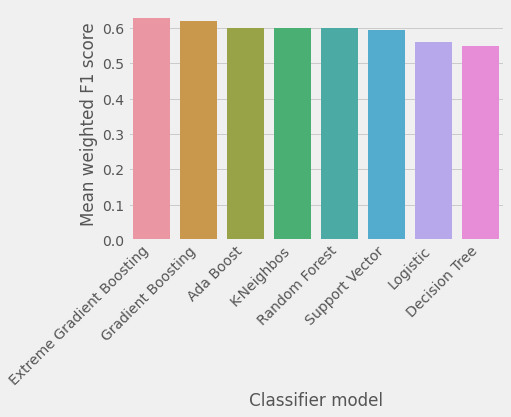

In [ ]:
sns.barplot(data=model_comparison_results_df, x='Classifier model', y='Mean weighted F1 score')
plt.xticks(rotation=45, ha='right')

Observations:
1. Extreme gradient boosting machine classifier has the highest mean weighted f1 score (with very small margin) from 10-fold cross validation. 

Lets select XGBM classifier as our model.

# Model optimization

## Functions for performance summary

In [ ]:
def plot_label_distributions(y_actual_series, y_estimated_series, data_set_name='Train'):
    """
    - Tejas Chaudhari
    """
    # Get actual train labels dataframe
    train_actual_labels_distributions_df = pd.DataFrame()
    train_actual_labels_distributions_df['Labels'] = y_actual_series
    train_actual_labels_distributions_df['Actual/estimated'] = 'Actual'

    # Get predicted train labels dataframe
    train_estimated_labels_distributions_df = pd.DataFrame()
    train_estimated_labels_distributions_df['Labels'] = y_estimated_series
    train_estimated_labels_distributions_df['Actual/estimated'] = 'Estimated'

    # Merge actual and predicted
    train_labels_distributions_df = pd.concat([train_actual_labels_distributions_df, train_estimated_labels_distributions_df], axis=0)

    # Plot
    sns.countplot(data=train_labels_distributions_df, x='Labels', hue='Actual/estimated', palette='tab10')
    plt.title(f'Label distributions for {data_set_name} data')
    plt.show()

In [ ]:
def get_classification_performance_summary(fitted_model, X_train, X_test, target_classes_dict):
    """
    - Tejas Chaudhari
    """

    # Get predictions on train data
    y_train_estimated_series = pd.Series(fitted_model.predict(X_train), index=X_train.index)

    # Get predictions on test data
    y_test_estimated_series = pd.Series(fitted_model.predict(X_test), index=X_test.index)

    # Get confurion matrix array on train data
    train_confusion_matrix_array = metrics.confusion_matrix(y_true=y_train, y_pred=y_train_estimated_series, labels=list(target_classes_dict.keys()))

    # Convert to dataframe
    train_confusion_matrix_df = pd.DataFrame(train_confusion_matrix_array, columns=list(target_classes_dict.values()))

    # Plot train confusion matrix
    sns.heatmap(train_confusion_matrix_df, yticklabels=list(target_classes_dict.values()),  annot=True, fmt='.0f')
    plt.title('Confusion matrix for train data')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    print('--'*50)

    # Get confurion matrix array on test data
    test_confusion_matrix_array = metrics.confusion_matrix(y_true=y_test, y_pred=y_test_estimated_series, labels=list(target_classes_dict.keys()))

    # Convert to dataframe
    test_confusion_matrix_df = pd.DataFrame(test_confusion_matrix_array, columns=list(target_classes_dict.values()))

    # Plot test confusion matrix
    sns.heatmap(test_confusion_matrix_df, yticklabels=list(target_classes_dict.values()),  annot=True, fmt='.0f')
    plt.title('Confusion matrix for test data')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    print('__'*50, '\n')

    # Get and display classification report for train data
    train_classification_report = metrics.classification_report(y_true=y_train, y_pred=y_train_estimated_series)
    print('Classification report for train data:')
    print(train_classification_report)
    print('--'*50)

    # Get and display classification report for test data
    test_classification_report = metrics.classification_report(y_true=y_test, y_pred=y_test_estimated_series)
    print('Classification report for test data:')
    print(test_classification_report)
    print('__'*50, '\n')

    # Plot train label distribution
    plot_label_distributions(y_train, y_train_estimated_series, data_set_name='Train')
    print('--'*50)

    # Plot test label distribution
    plot_label_distributions(y_test, y_test_estimated_series, data_set_name='Test')

## Get class weights


Source:
https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost

In [ ]:
from sklearn.utils import class_weight
train_classes_weights_list = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

test_class_weights_list = class_weight.compute_sample_weight(class_weight='balanced', y=y_test)

## Ada boost (trials)

### Randomized search cv

In [ ]:
ada_boost_hyperparam_distributions = {
    'n_estimators': np.around(a=np.arange(start=10, stop=500, step=50), decimals=0),
    'learning_rate': np.around(a=np.arange(start=0.01, stop=1.0, step=0.05), decimals=2)
}

# Create model instance
ada_boost_randomized_search_cv_model = RandomizedSearchCV(estimator=AdaBoostClassifier(random_state=7), param_distributions=ada_boost_hyperparam_distributions,
                                                          random_state=7, scoring=weighted_f1_scorer, n_jobs=-1, cv=10, verbose=4)

# Fit model
fitted_ada_boost_randomized_search_cv_model = ada_boost_randomized_search_cv_model.fit(scaled_X_train, y_train)

# Save model
save_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_ada_boost_randomized_search_cv_model.joblib'
dump(fitted_ada_boost_randomized_search_cv_model, save_path)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


['/content/drive/MyDrive/EE 769/Project/Stored data/fitted_ada_boost_randomized_search_cv_model.joblib']

In [ ]:
# Load model
saved_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_ada_boost_randomized_search_cv_model.joblib'
fitted_ada_boost_randomized_search_cv_model = load(saved_path)

# Display
print('Best estimator:')
display(fitted_ada_boost_randomized_search_cv_model.best_estimator_)

Best estimator:


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.41,
                   n_estimators=310, random_state=7)

In [ ]:
# Get cross validation score
f1_weighted_cross_validation_scores_list = cross_val_score(estimator=fitted_ada_boost_randomized_search_cv_model.best_estimator_,
                                                            X=scaled_X_train, y=y_train, scoring=weighted_f1_scorer,  cv=10)

# Display cross validation score
print('Weighted F-1 score from cross validation:')
print(f1_weighted_cross_validation_scores_list.mean())

# Get predictions on train data
y_train_predicted_series = pd.Series(fitted_ada_boost_randomized_search_cv_model.predict(scaled_X_train), index=scaled_X_train.index)

# Get weighted f1 score on train
print('Weighted F-1 score on train data:')
print(metrics.f1_score(y_true=y_train, y_pred=y_train_predicted_series, average='weighted'))

# Get predictions on test
y_test_predicted_series = pd.Series(fitted_ada_boost_randomized_search_cv_model.predict(scaled_X_test), index=scaled_X_test.index)

# Display weighted f1 score on test
print('Weighted F-1 score on test data:')
print(metrics.f1_score(y_true=y_test, y_pred=y_test_predicted_series, average='weighted'))

Weighted F-1 score from cross validation:
0.6227180659063201
Weighted F-1 score on train data:
0.6766832358509388
Weighted F-1 score on test data:
0.6100021090290749


Observations:
1. Even if the weighted F-1 score from cross-validation improved slightly. However, the model does not perform well on the test. 
2. This looks like the case of overfitting. Lets perform futher tunning through grid search

### Grid search cv

In [ ]:
ada_boost_hyperparams_grid = {
    'n_estimators': np.around(a=np.arange(start=200, stop=500, step=50), decimals=0),
    'learning_rate': np.around(a=np.arange(start=0.1, stop=1.0, step=0.1), decimals=2)
}

# Create model instance
ada_boost_grid_search_cv_model = GridSearchCV(estimator=AdaBoostClassifier(random_state=7), param_grid=ada_boost_hyperparams_grid,
                                             scoring=weighted_f1_scorer, n_jobs=-1, cv=10, verbose=4)

# Fit model
fitted_ada_boost_grid_search_cv_model = ada_boost_grid_search_cv_model.fit(scaled_X_train, y_train)

# Save model
save_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_ada_boost_grid_search_cv_model.joblib'
dump(fitted_ada_boost_grid_search_cv_model, save_path)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 22.3min finished


['/content/drive/MyDrive/EE 769/Project/Stored data/fitted_ada_boost_grid_search_cv_model.joblib']

In [ ]:
# Load model
saved_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_ada_boost_grid_search_cv_model.joblib'
fitted_ada_boost_grid_search_cv_model = load(saved_path)

# Display
print('Best estimator:')
display(fitted_ada_boost_grid_search_cv_model.best_estimator_)

Best estimator:


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=200, random_state=7)

In [ ]:
# Get cross validation score
f1_weighted_cross_validation_scores_list = cross_val_score(estimator=fitted_ada_boost_grid_search_cv_model.best_estimator_,
                                                            X=scaled_X_train, y=y_train, scoring=weighted_f1_scorer,  cv=10)

# Display cross validation score
print('Weighted F-1 score from cross validation')
print(f1_weighted_cross_validation_scores_list.mean())

# Get predictions on train data
y_train_predicted_series = pd.Series(fitted_ada_boost_grid_search_cv_model.predict(scaled_X_train), index=scaled_X_train.index)

# Get weighted f1 score on train
print('Weighted F-1 score on train data:')
print(metrics.f1_score(y_true=y_train, y_pred=y_train_predicted_series, average='weighted'))

# Get predictions on test
y_test_predicted_series = pd.Series(fitted_ada_boost_grid_search_cv_model.predict(scaled_X_test), index=scaled_X_test.index)

# Display weighted f1 score on test
print('Weighted F-1 score on test data:')
print(metrics.f1_score(y_true=y_test, y_pred=y_test_predicted_series, average='weighted'))

Weighted F-1 score from cross validation
0.6256832044487387
Weighted F-1 score on train data:
0.6750702332985724
Weighted F-1 score on test data:
0.617354381657854


Observations:
1. Ada boost is still underpforming in one time scores. Lets try hyperparameter tunning in XGBoost, which was on the top of the list

## Extreme gradient boosting classifier (XGBoost)

### Performance without optimization

In [ ]:
model_performance_comparison(scaled_X_train, y_train, {'XGBC': XGBClassifier(random_state=7)}, weighted_f1_scorer)

Trying XGBC: 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  ................................................................
[CV] .................................... , score=0.605, total=   4.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[CV]  ................................................................
[CV] .................................... , score=0.626, total=   4.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[CV]  ................................................................
[CV] .................................... , score=0.617, total=   3.9s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[CV]  ................................................................
[CV] .................................... , score=0.642, total=   3.9s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.8s remaining:    0.0s
[CV]  ...........

Classifier model  Mean weighted F1 score  Std weighted F1 score
0             XGBC                 0.62934               0.012238

Classifier model  Mean weighted F1 score  Std weighted F1 score
0             XGBC                 0.62934               0.012238

In [ ]:
# Create model instance
XGBC_model = XGBClassifier(random_state=7)

# Fit model on train data
fitted_XGBC_model = XGBC_model.fit(scaled_X_train, y_train)

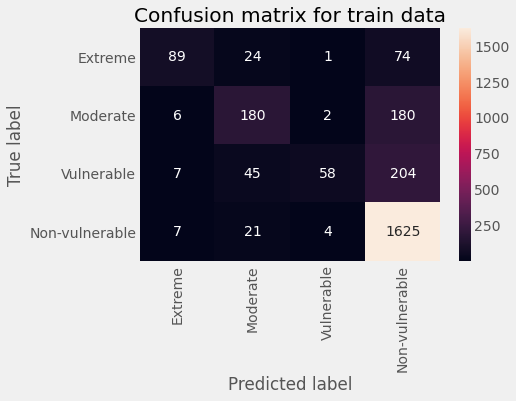

----------------------------------------------------------------------------------------------------


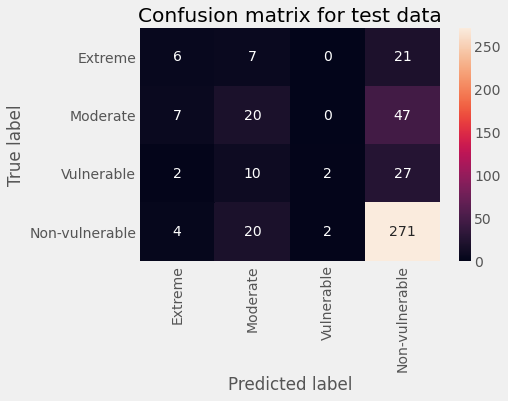

____________________________________________________________________________________________________ 

Classification report for train data:
              precision    recall  f1-score   support

         1.0       0.82      0.47      0.60       188
         2.0       0.67      0.49      0.56       368
         3.0       0.89      0.18      0.31       314
         4.0       0.78      0.98      0.87      1657

    accuracy                           0.77      2527
   macro avg       0.79      0.53      0.58      2527
weighted avg       0.78      0.77      0.73      2527

----------------------------------------------------------------------------------------------------
Classification report for test data:
              precision    recall  f1-score   support

         1.0       0.32      0.18      0.23        34
         2.0       0.35      0.27      0.31        74
         3.0       0.50      0.05      0.09        41
         4.0       0.74      0.91      0.82       297

    accuracy  

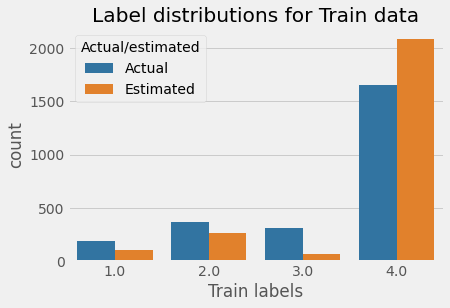

----------------------------------------------------------------------------------------------------


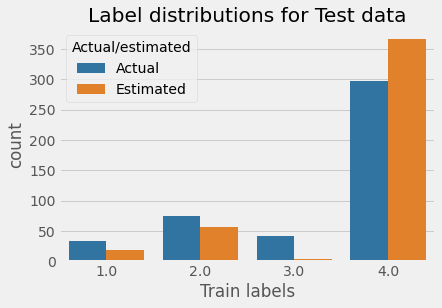

In [ ]:
# Set target classses dictionary for plotting with labels
target_classes_dict = OrderedDict({
    1: 'Extreme',
    2: 'Moderate',
    3: 'Vulnerable',
    4: 'Non-vulnerable'
})

# Get classification performance summary
get_classification_performance_summary(fitted_XGBC_model, scaled_X_train, scaled_X_test, target_classes_dict=target_classes_dict)

Observations:
1. Weighted F-1 score on test before optimization = 0.6214
2. Weighted F-1 score using cross-validation before optimization = 0.6253

#### Grid search CV

In [ ]:
# Define hyperparameters dictionary
XGBC_hyperparams_dict = {
    'eta': [0.05, 0.1, 1], # Learning rate, prevents overfitting, range: (0, 1]
    'max_depth': [2, 4, 6, 8, 10]
}

# Define scorer
weighted_f1_scorer = metrics.make_scorer(score_func=metrics.f1_score, greater_is_better=True,
                                        average='weighted') # Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance

# Create estimator instance
estimator_model = XGBClassifier(booster='gbtree', objective='multi:softmax', num_class=4, random_state=7, sample_weights=train_classes_weights_list)

# Create grid search cv model instance
XGBC_grid_search_cv_model = GridSearchCV(estimator=estimator_model, param_grid=XGBC_hyperparams_dict, scoring=weighted_f1_scorer, cv=10, verbose=4)
                                        #  , n_jobs=-1) 
                                        #  cv=10)

# Fit model on train data
fitted_XGBC_grid_search_cv_model = XGBC_grid_search_cv_model.fit(scaled_X_train, y_train)

# Save model
save_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_XGBC_grid_search_cv_model.joblib'
dump(fitted_XGBC_grid_search_cv_model, save_path)


Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] eta=0.05, max_depth=2 ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... eta=0.05, max_depth=2, score=0.576, total=   2.9s
[CV] eta=0.05, max_depth=2 ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] ............... eta=0.05, max_depth=2, score=0.624, total=   2.9s
[CV] eta=0.05, max_depth=2 ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s


[CV] ............... eta=0.05, max_depth=2, score=0.593, total=   2.9s
[CV] eta=0.05, max_depth=2 ...........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.8s remaining:    0.0s


[CV] ............... eta=0.05, max_depth=2, score=0.627, total=   2.9s
[CV] eta=0.05, max_depth=2 ...........................................
[CV] ............... eta=0.05, max_depth=2, score=0.612, total=   3.0s
[CV] eta=0.05, max_depth=2 ...........................................
[CV] ............... eta=0.05, max_depth=2, score=0.592, total=   2.9s
[CV] eta=0.05, max_depth=2 ...........................................
[CV] ............... eta=0.05, max_depth=2, score=0.626, total=   2.9s
[CV] eta=0.05, max_depth=2 ...........................................
[CV] ............... eta=0.05, max_depth=2, score=0.628, total=   2.9s
[CV] eta=0.05, max_depth=2 ...........................................
[CV] ............... eta=0.05, max_depth=2, score=0.627, total=   3.0s
[CV] eta=0.05, max_depth=2 ...........................................
[CV] ............... eta=0.05, max_depth=2, score=0.620, total=   2.9s
[CV] eta=0.05, max_depth=4 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 19.7min finished


['/content/drive/MyDrive/EE 769/Project/Stored data/fitted_XGBC_grid_search_cv_model.joblib']

In [ ]:
# Load model
saved_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_XGBC_grid_search_cv_model.joblib'
fitted_XGBC_grid_search_cv_model = load(saved_path)

# Display best estimator
print('Best estimator:')
display(fitted_XGBC_grid_search_cv_model.best_estimator_)

Best estimator:


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.05, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, n_estimators=100, n_jobs=1,
              nthread=None, num_class=4, objective='multi:softprob',
              random_state=7, reg_alpha=0, reg_lambda=1,
              sample_weights=array([3.36037234, 0.38126132, 2.01194268, ..., 1.71671196, 3.36037234,
       0.38126132]),
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              verbosity=1)

In [ ]:
# Display
print('Weighted F-1 score from 10-fold cross validation:')
print(fitted_XGBC_grid_search_cv_model.best_score_)

Weighted F-1 score from 10-fold cross validation:
0.629700644565147
Weighted F-1 score on train data:
0.9506075903451418
Weighted F-1 score on test data:
0.6282325848291629


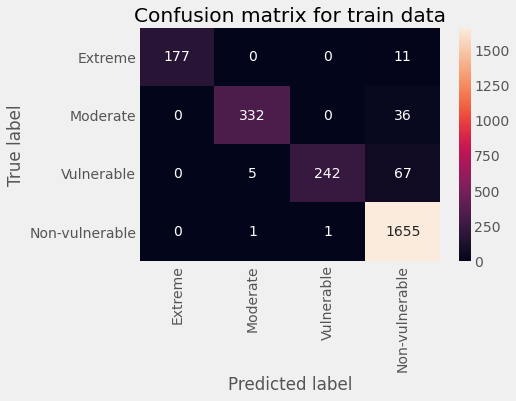

----------------------------------------------------------------------------------------------------


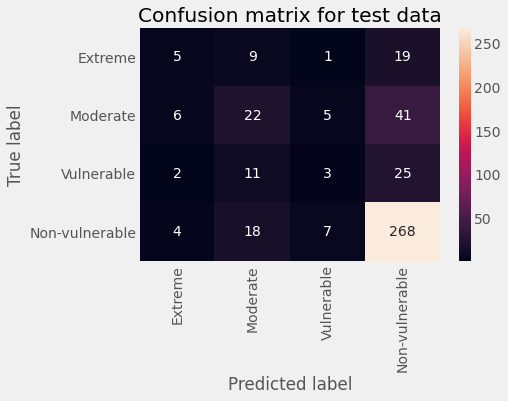

____________________________________________________________________________________________________ 

Classification report for train data:
              precision    recall  f1-score   support

         1.0       1.00      0.94      0.97       188
         2.0       0.98      0.90      0.94       368
         3.0       1.00      0.77      0.87       314
         4.0       0.94      1.00      0.97      1657

    accuracy                           0.95      2527
   macro avg       0.98      0.90      0.94      2527
weighted avg       0.95      0.95      0.95      2527

----------------------------------------------------------------------------------------------------
Classification report for test data:
              precision    recall  f1-score   support

         1.0       0.29      0.15      0.20        34
         2.0       0.37      0.30      0.33        74
         3.0       0.19      0.07      0.11        41
         4.0       0.76      0.90      0.82       297

    accuracy  

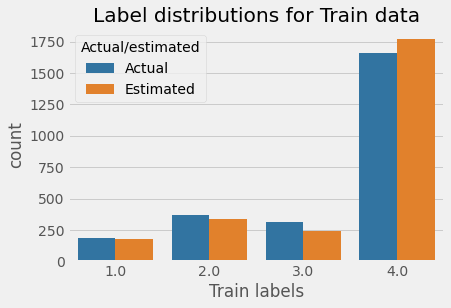

----------------------------------------------------------------------------------------------------


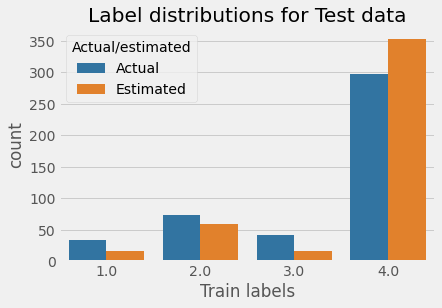

In [ ]:
# Set target classses dictionary for plotting with labels
target_classes_dict = OrderedDict({
    1: 'Extreme',
    2: 'Moderate',
    3: 'Vulnerable',
    4: 'Non-vulnerable'
})

# Get classification performance summary
get_classification_performance_summary(fitted_model=fitted_XGBC_grid_search_cv_model.best_estimator_, X_train=scaled_X_train,
                                       X_test=scaled_X_test, target_classes_dict=target_classes_dict)

Observations:
1. Weighted F-1 score on test after optimization = 0.6310
2. Weighted F-1 score using cross-validatioon after optimization = 0.6323

Observations:
1. Slightly improved cross validation score.
2. Overfitting on train data. However score on test data is better than ada boost.
3. Further regularization can be done to reduce overfitting. However for now lets move on with this model.

### Feature selection

We will use feature selection from random forest classifier model

In [ ]:
weighted_f1_scorer = metrics.make_scorer(score_func=metrics.f1_score, greater_is_better=True,
                                            average='weighted')

# Store the best estimator from grid search
best_fitted_XGBC_model = fitted_XGBC_grid_search_cv_model.best_estimator_

# Create instance of recursive feature eliminator  with cross-validation
weighted_f1_XGBC_RFECV_model = RFECV(estimator=best_fitted_XGBC_model, scoring=weighted_f1_scorer, 
                                     step=10, # number of features to remove at each iteration
                                     cv=10, verbose=100)

# Fit the recursive feature estimator on training data
fitted_weighted_f1_XGBC_RFECV_model = weighted_f1_XGBC_RFECV_model.fit(scaled_X_data, y_data)

# Save model
save_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_weighted_f1_XGBC_RFECV_model.joblib'
dump(fitted_weighted_f1_XGBC_RFECV_model, save_path)


Fitting estimator with 207 features.
Fitting estimator with 197 features.
Fitting estimator with 187 features.
Fitting estimator with 177 features.
Fitting estimator with 167 features.
Fitting estimator with 157 features.
Fitting estimator with 147 features.
Fitting estimator with 137 features.
Fitting estimator with 127 features.
Fitting estimator with 117 features.
Fitting estimator with 107 features.
Fitting estimator with 97 features.
Fitting estimator with 87 features.
Fitting estimator with 77 features.
Fitting estimator with 67 features.
Fitting estimator with 57 features.
Fitting estimator with 47 features.
Fitting estimator with 37 features.
Fitting estimator with 27 features.
Fitting estimator with 17 features.
Fitting estimator with 7 features.
Fitting estimator with 207 features.
Fitting estimator with 197 features.
Fitting estimator with 187 features.
Fitting estimator with 177 features.
Fitting estimator with 167 features.
Fitting estimator with 157 features.
Fitting esti

['/content/drive/MyDrive/EE 769/Project/Stored data/fitted_weighted_f1_XGBC_RFECV_model.joblib']

In [ ]:
# Load model
saved_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_weighted_f1_XGBC_RFECV_model.joblib'
fitted_weighted_f1_XGBC_RFECV_model = load(saved_path)

Input train data before eliminating features: 


sanitario5  energcocinar1  tipovivi1  tipovivi2  pisocemento  paredzinc  \
1238         0.0            0.0        1.0        0.0          1.0        0.0   
2028         0.0            0.0        1.0        0.0          0.0        0.0   
2245         0.0            0.0        1.0        0.0          1.0        0.0   
2453         0.0            0.0        1.0        0.0          0.0        0.0   
2940         0.0            0.0        1.0        0.0          0.0        0.0   
...          ...            ...        ...        ...          ...        ...   
2676         0.0            0.0        0.0        0.0          1.0        0.0   
2657         0.0            0.0        1.0        0.0          1.0        0.0   
2241         0.0            0.0        0.0        0.0          1.0        0.0   
338          0.0            0.0        1.0        0.0          1.0        0.0   
883          0.0            0.0        1.0        0.0          0.0        0.0   

      pareddes  etecho1  etecho2  coopele  hogar_total  paredmad  lugar6  \
1238       0.0      0.0      0.0      0.0          3.0       0.0     0.0   
2028       0.0      0.0      0.0      0.0          2.0       0.0     0.0   
2245       0.0      0.0      1.0      0.0          3.0       0.0     0.0   
2453       0.0      1.0      0.0      0.0          4.0       1.0     0.0   
2940       0.0      0.0      0.0      1.0          3.0       0.0     1.0   
...        ...      ...      ...      ...          ...       ...     ...   
2676       0.0      0.0      0.0      0.0          1.0       0.0     0.0   
2657       1.0      1.0      0.0      0.0          1.0       0.0     0.0   
2241       0.0      0.0      0.0      0.0          1.0       0.0     0.0   
338        0.0      0.0      1.0      0.0          5.0       0.0     0.0   
883        0.0      0.0      1.0      0.0          4.0       0.0     0.0   

      television  lugar1  r4h3  r4m2  lugar2  paredother  sanitario3  rooms  \
1238         0.0     1.0   2.0   1.0     0.0         0.0         1.0    4.0   
2028         0.0     0.0   1.0   1.0     0.0         0.0         1.0    3.0   
2245         1.0     0.0   1.0   2.0     0.0         0.0         1.0    6.0   
2453         0.0     0.0   3.0   1.0     0.0         0.0         1.0    7.0   
2940         0.0     0.0   2.0   1.0     0.0         0.0         1.0    3.0   
...          ...     ...   ...   ...     ...         ...         ...    ...   
2676         0.0     0.0   1.0   0.0     0.0         0.0         1.0    4.0   
2657         0.0     0.0   0.0   1.0     0.0         0.0         1.0    2.0   
2241         1.0     0.0   1.0   0.0     0.0         0.0         1.0    4.0   
338          1.0     1.0   2.0   3.0     0.0         0.0         1.0    6.0   
883          1.0     1.0   2.0   2.0     0.0         0.0         1.0    5.0   

      v14a  pisomoscer  epared1  paredfibras  energcocinar3  sanitario6  \
1238   1.0         0.0      0.0          0.0            1.0         0.0   
2028   1.0         1.0      0.0          0.0            0.0         0.0   
2245   1.0         0.0      0.0          0.0            1.0         0.0   
2453   1.0         0.0      0.0          0.0            0.0         0.0   
2940   1.0         1.0      0.0          0.0            0.0         0.0   
...    ...         ...      ...          ...            ...         ...   
2676   1.0         0.0      0.0          0.0            0.0         0.0   
2657   1.0         0.0      1.0          0.0            0.0         0.0   
2241   1.0         0.0      0.0          0.0            0.0         0.0   
338    1.0         0.0      0.0          0.0            1.0         0.0   
883    1.0         1.0      0.0          0.0            1.0         0.0   

      tipovivi4  cielorazo  hogar_adul  overcrowding  edjefa  hacapo  eviv1  \
1238        0.0        0.0         2.0      1.500000     0.0     0.0    0.0   
2028        0.0        1.0         2.0      1.000000    11.0     0.0    0.0   
2245        0.0        1.0       

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Input train data after eliminating features: 


etecho1  coopele  lugar1  r4h3  pisomoscer  epared1  edjefa  hacapo  \
0         0.0      0.0     1.0   2.0         0.0      0.0     0.0     0.0   
1         0.0      0.0     0.0   1.0         1.0      0.0    11.0     0.0   
2         0.0      0.0     0.0   1.0         0.0      0.0     0.0     0.0   
3         1.0      0.0     0.0   3.0         0.0      0.0     0.0     0.0   
4         0.0      1.0     0.0   2.0         1.0      0.0     0.0     0.0   
...       ...      ...     ...   ...         ...      ...     ...     ...   
2968      0.0      0.0     0.0   1.0         0.0      0.0     0.0     0.0   
2969      1.0      0.0     0.0   0.0         0.0      1.0     2.0     0.0   
2970      0.0      0.0     0.0   1.0         0.0      0.0     0.0     0.0   
2971      0.0      0.0     1.0   2.0         0.0      0.0     6.0     0.0   
2972      0.0      0.0     1.0   2.0         1.0      0.0     0.0     0.0   

      eviv1        v2a1  energcocinar4  techozinc  qmobilephone  r4h2  \
0       0.0       0.000            0.0        1.0           2.0   1.0   
1       0.0       0.000            0.0        1.0           2.0   1.0   
2       0.0       0.000            0.0        1.0           2.0   1.0   
3       0.0       0.000            1.0        1.0           3.0   3.0   
4       0.0       0.000            1.0        1.0           1.0   2.0   
...     ...         ...            ...        ...           ...   ...   
2968    0.0  101202.715            0.0        1.0           1.0   1.0   
2969    1.0       0.000            0.0        1.0           0.0   0.0   
2970    0.0   50000.000            0.0        1.0           2.0   1.0   
2971    0.0       0.000            0.0        1.0           5.0   2.0   
2972    0.0       0.000            0.0        1.0           4.0   2.0   

      hogar_nin  dependency  area2  pisonotiene  r4t2  abastaguadentro  v18q1  \
0           1.0         0.5    0.0          0.0   2.0              1.0    0.0   
1           0.0         0.0    0.0          0.0   2.0              1.0    0.0   
2           1.0         0.5    0.0          0.0   3.0              1.0    0.0   
3           0.0         0.0    1.0          0.0   4.0              1.0    0.0   
4           0.0         0.5    1.0          0.0   3.0              1.0    0.0   
...         ...         ...    ...          ...   ...              ...    ...   
2968        0.0         0.0    1.0          0.0   1.0              1.0    0.0   
2969        0.0         8.0    1.0          0.0   1.0              0.0    0.0   
2970        0.0         0.0    0.0          0.0   1.0              1.0    0.0   
2971        0.0         0.0    0.0          0.0   5.0              1.0    0.0   
2972        1.0         1.0    0.0          0.0   4.0              1.0    0.0   

      etecho3  computer  epared3  paredblolad  eviv3  sanitario2  \
0         1.0       0.0      1.0          0.0    0.0         0.0   
1         1.0       0.0      1.0          1.0    1.0         0.0   
2         0.0       0.0      1.0          1.0    1.0         0.0   
3         0.0       0.0      0.0          0.0    0.0         0.0   
4         1.0       0.0      1.0          0.0    1.0         0.0   
...       ...       ...      ...          ...    ...         ...   
2968      1.0       0.0      1.0          0.0    1.0         0.0   
2969      0.0       0.0      0.0          0.0    0.0         0.0   
2970      1.0       0.0      1.0          0.0    0.0         0.0   
2971      0.0       0.0      0.0          1.0    0.0         0.0   
2972      0.0       0.0      1.0          1.0    1.0         0.0   

      instlevel1-mean  parentesco9-mean   age-mean  age-min    age-std  \
0            0.333333               0.0  18.666667      3.0  14.011900   
1            0.000000               0.0  34.000000     21.0  18.384776   
2            0.000000               0.0  42.000000     14.0  24.269322   
3            0.000000               0.0  46.750000     32.0  15.370426   
4            0.333333               0.0  53.

________________________________________________________________________________________________________________________________________________________________________________________________________ 

Number of features selected in recursive feature elimination with cross validation using RFC and weighted f1 scoring:     47
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


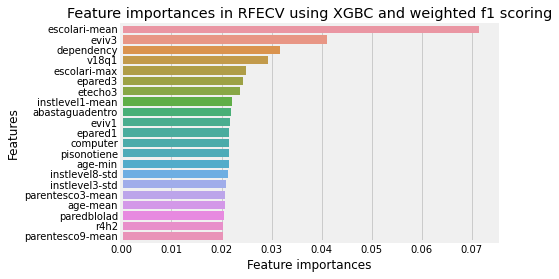

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Text(0, 0.5, 'Weighted F-1 score')

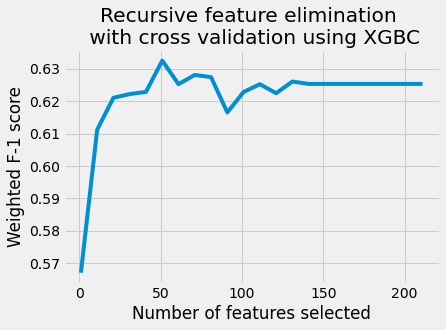

In [ ]:
# Get selected  features list
RFECV_selected_features_list = scaled_X_data.columns[fitted_weighted_f1_XGBC_RFECV_model.support_]

# Get reduced input training dataframe
reduced_weighted_f1_XGBC_RFECV_X_train_array = fitted_weighted_f1_XGBC_RFECV_model.transform(scaled_X_data)
reduced_weighted_f1_XGBC_RFECV_X_train = pd.DataFrame(reduced_weighted_f1_XGBC_RFECV_X_train_array, columns=RFECV_selected_features_list )

# Display input train data before feature elimination
print(f'Input train data before eliminating features: ')
display(scaled_X_data)
print('--'*100)

# Display input train data after feature elimination
print(f'Input train data after eliminating features: ')
display(reduced_weighted_f1_XGBC_RFECV_X_train)
print('__'*100, '\n')


# Number of features selected
print(f'Number of features selected in recursive feature elimination with cross validation using RFC and weighted f1 scoring: \
    {fitted_weighted_f1_XGBC_RFECV_model.n_features_}')
print('--'*100)

# Get Feature importance
feature_importances_list = fitted_weighted_f1_XGBC_RFECV_model.estimator_.feature_importances_

# Create a dataframe 
feature_importances_df = pd.DataFrame()
feature_importances_df['Features'] = RFECV_selected_features_list
feature_importances_df['Feature importances'] = feature_importances_list

# Sort dataframe according to feature importances
feature_importances_df.sort_values(by='Feature importances', ascending=False, inplace=True)


# Plot feature importances
sns.barplot(x=feature_importances_df['Feature importances'][0:21], y=feature_importances_df['Features'][0:21])
plt.title('Feature importances in RFECV using XGBC and weighted f1 scoring')
plt.show()
print('--'*100)

# Calculate number of grid scores
n_features = 207 # Total number of features before elimination
min_features_to_select = 1
step = 10
n_grid_scores = int(np.ceil((n_features - min_features_to_select) / step) + 1)


# Plot 
plt.style.use('fivethirtyeight')
sns.lineplot(x=range(min_features_to_select, n_grid_scores*step + min_features_to_select, 10), 
         y=fitted_weighted_f1_XGBC_RFECV_model.grid_scores_)
plt.title('Recursive feature elimination \n with cross validation using XGBC')
plt.xlabel('Number of features selected')
plt.ylabel('Weighted F-1 score')

In [ ]:
f1_weighted_cross_validation_scores_list = cross_val_score(estimator=fitted_XGBC_grid_search_cv_model.best_estimator_, 
                                                           X=scaled_X_train[RFECV_selected_features_list], y=y_train, 
                                                           scoring=weighted_f1_scorer, cv=10, verbose=4, n_jobs=-1)

# Display
print('Weighted F-1 score from 10-fold cross validation:')
print(f1_weighted_cross_validation_scores_list.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Weighted F-1 score from 10-fold cross validation:
0.6284886261996774


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.0s finished


### Performance summary after feature elimination and optimization

In [ ]:
# Create model instance with best parameters from grid search cv
XGBC_model_v2 = XGBClassifier(**fitted_XGBC_grid_search_cv_model.best_params_)

# Fit model on train data with selected features
fitted_XGBC_model_v2 = XGBC_model_v2.fit(scaled_X_train[RFECV_selected_features_list], y_train)


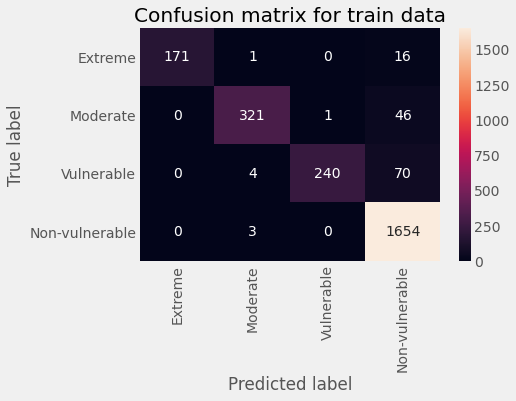

----------------------------------------------------------------------------------------------------


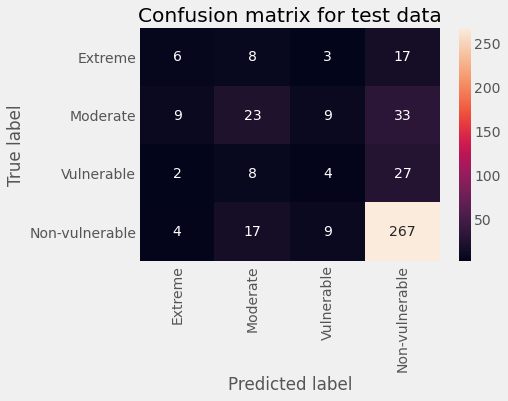

____________________________________________________________________________________________________ 

Classification report for train data:
              precision    recall  f1-score   support

         1.0       1.00      0.91      0.95       188
         2.0       0.98      0.87      0.92       368
         3.0       1.00      0.76      0.86       314
         4.0       0.93      1.00      0.96      1657

    accuracy                           0.94      2527
   macro avg       0.97      0.89      0.92      2527
weighted avg       0.95      0.94      0.94      2527

----------------------------------------------------------------------------------------------------
Classification report for test data:
              precision    recall  f1-score   support

         1.0       0.29      0.18      0.22        34
         2.0       0.41      0.31      0.35        74
         3.0       0.16      0.10      0.12        41
         4.0       0.78      0.90      0.83       297

    accuracy  

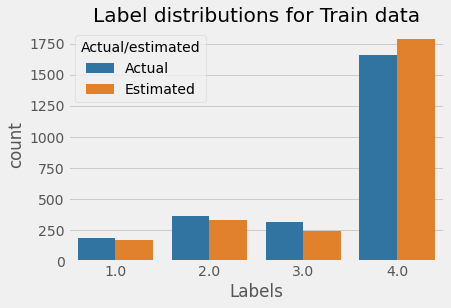

----------------------------------------------------------------------------------------------------


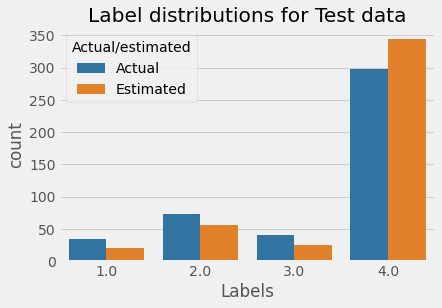

In [ ]:
# Set target classses dictionary for plotting with labels
target_classes_dict = OrderedDict({
    1: 'Extreme',
    2: 'Moderate',
    3: 'Vulnerable',
    4: 'Non-vulnerable'
})

# Get classification performance summary
get_classification_performance_summary(fitted_model=fitted_XGBC_model_v2, X_train=scaled_X_train[RFECV_selected_features_list],
                                       X_test=scaled_X_test[RFECV_selected_features_list], target_classes_dict=target_classes_dict)

Observations:
1. Weighted F-1 score slightly increased.
2. Estimated label distribution is close to the actual with small difference.

### Visualize

In [ ]:
def visusalize_TSNE_2D_embedding(data_df, predicted_cluster_labels_series, random_state=7):
    """
    - Tejas Chaudhari
    """

    # Get T-sne 2D embedding for visualization
    # Create T-sne model instance
    TSNE_model = TSNE(n_components=2, random_state=random_state, n_jobs=-1)

    # Fit and embed the data
    TSNE_embedded_data_array = TSNE_model.fit_transform(data_df)

    # Conver to dataframe
    TSNE_embedded_data_df = pd.DataFrame(data=TSNE_embedded_data_array, columns=['Embedded feature 1', 'Embedded feature 2'],
                                            index=data_df.index)
    
    # Create figure and axes array
    figure, axes_array = plt.subplots(1, 1, figsize=(10, 5))

    # Visualize train data clusters
    sns.scatterplot(data=TSNE_embedded_data_df.assign(predicted_cluster_labels=predicted_cluster_labels_series),
                    x='Embedded feature 1', y='Embedded feature 2', hue='predicted_cluster_labels', s=100,
                    palette='tab10', style='predicted_cluster_labels', ax=axes_array)
    axes_array.legend(markerscale=1.25)
    plt.show()

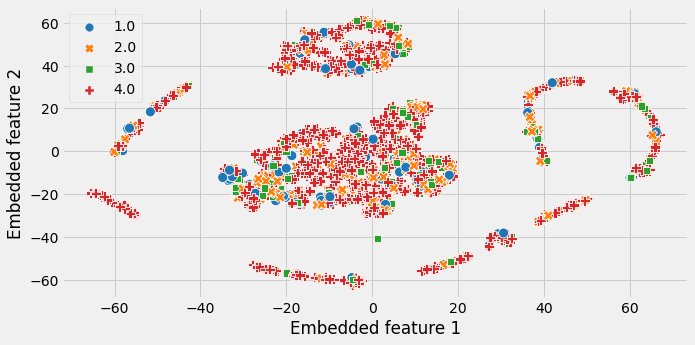

In [ ]:
visusalize_TSNE_2D_embedding(X_train, y_train)

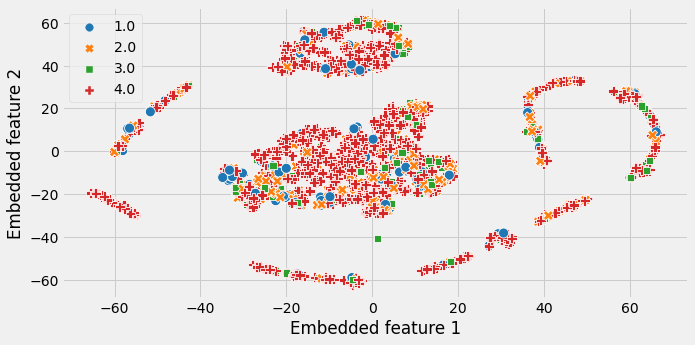

In [ ]:
visusalize_TSNE_2D_embedding(X_train, y_train_predicted_series)

# Credits

1. Instructor [Prof. Amit Sethi](https://www.ee.iitb.ac.in/~asethi/) and TAs of the course EE 769.

2. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

3. T. Chen and C. Guestrin, “XGBoost: A scalable tree boosting system,” in Proceedings of the ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, Aug. 2016, vol. 13-17-August-2016, pp. 785–794, doi: 10.1145/2939672.2939785.

# Additional trials

### Randomized search CV

In [ ]:
# Define hyperparameters dictionary
XGBC_hyperparams_dict = {
    'eta': [0.05, 0.1, 1], # Learning rate, prevents overfitting, range: (0, 1]
    
}

# Define scorer
weighted_f1_scorer = metrics.make_scorer(score_func=metrics.f1_score, greater_is_better=True,
                                        average='weighted') # Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance

# Create estimator instance
estimator_model = XGBClassifier(booster='gbtree', tree_method='gpu_hist', sample_weights=train_classes_weights_list)

# Create grid search cv model instance
XGBC_randomized_search_cv_model = RandomizedSearchCV(estimator=estimator_model, param_distributions=XGBC_hyperparams_dict, scoring=weighted_f1_scorer, cv=10) 
                                        #  verbose=3, n_jobs=-1) 
                                        #  cv=10)

# Fit model on train data
fitted_XGBC_randomized_search_cv_model = XGBC_randomized_search_cv_model.fit(scaled_X_train, y_train)

# Save model
save_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_XGBC_randomized_search_cv_model.joblib'
dump(fitted_XGBC_randomized_search_cv_model, save_path)

In [ ]:
# Load model
saved_path = '/content/drive/MyDrive/EE 769/Project/Stored data/fitted_XGBC_randomized_search_cv_model.joblib'
fitted_XGBC_randomized_search_cv_model = load(saved_path)

# Display
fitted_XGBC_randomized_search_cv_model.best_estimator_

## Class weights trial

In [ ]:
# Trial of adding class weights
train_classes_weights_list = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)



fitted_XGBC_balanced_model =XGBClassifier().fit(X=scaled_X_train, y=y_train, sample_weight=train_classes_weights_list)

print(metrics.f1_score(y_train, fitted_XGBC_balanced_model.predict(scaled_X_train), average='weighted'))

f1_weighted_cross_validation_scores_list = cross_val_score(estimator=XGBC_grid_search_cv_model.best_estimator_, 
                                                           X=scaled_X_train, y=y_train, scoring=weighted_f1_scorer, cv=10, verbose=4, n_jobs=-1)

# Display
print('Weighted F-1 score from 10-fold cross validation:')
print(f1_weighted_cross_validation_scores_list.mean())


0.7447109285645088


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Weighted F-1 score from 10-fold cross validation:
0.6391671976002455


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


## Light gradient boosting machine classifier

Useful resources:
1. https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [ ]:
params = {
'boosting_type': 'gbdt',
'objective': 'multiclass',
'metric': 'multi_logloss',
'num_class':5,
'max_depth':8,
'num_leaves':200,
'learning_rate': 0.05,
'n_estimators':500
}
hyperparam_value = None
hyperparam_dict = {
    'learning_rate': hyperparam_value,
    'seed': 7
}

# Define inputs for the SVC classifier
n_trials = 25 # Number of bootstrapped samples
hyperparam_range = np.around(a=np.arange(start=0.01, stop=1.0, step=0.05), decimals=2) 
n_hyper_params = len(hyperparam_range)

# Train (tune parameters) and validate (tune hyper-parameters)
metric_matrix = np.zeros([n_hyper_params, n_trials])  # Initiate AUC matrix with hyper-parameters on rows and traials on columns

for hyperparam_index, hyperparam_value in enumerate(hyperparam_range): # Iterate over the hyper-parameter C
    print(f'Trying hyperparameter value: {hyperparam_value}')

    for trial_number in np.arange(0, n_trials): # Iterate over the trials
        # Create the data split as 80:20 for training_data:validation_data
        current_X_train, current_X_val, current_y_train, current_y_val  = train_test_split(X_train, y_train, train_size=0.8) 
        # Sequence of the variables above is reversed to avoid overwriting of values

        # Train and validate on training data
        model = LGBMClassifier(objective='multiclass', boosting_type='gbdt', random_state=7,**hyperparam_dict) # Define classifier. Probability True computes AUC
        fitted_model = model.fit(current_X_train, np.squeeze(current_y_train))  # Train and validate
        
        # Predict on validating data
        current_y_predicted = fitted_model.predict(current_X_val)

        # Compute AUC
        metric_matrix[hyperparam_index, trial_number] = metrics.f1_score( np.squeeze(current_y_val), current_y_predicted, average='weighted')
    print(metric_matrix)

# Compute the mean of AUC over the trials for each value of hyper-parameter
mean_metric_value = np.mean(metric_matrix, axis=1)

# Print hyperparameters range
print('Hyper parameter range:')
print(hyperparam_range)

# Print AUC and hyper-parameters
print('Mean f1 weighted:')
print(mean_metric_value)


# Plot AUC vs hyper-parameter
plt.plot(hyperparam_range, mean_metric_value)
plt.xlabel('Hyper parameter values')
plt.ylabel('Mean metric value')